# Proyecto de Clasificación para análisis de los sentimientos de las reseñas en productos de alimentación de Amazon

- Se proporciona el código y los pasos dados en cada fase del proyecto.
- Durante el desarrollo es habitual que después de hacer bloques de operaciones costosas computacionalmente, se vayan dando pasos intermedios donde se va almacenando el ficheros CSV los resultados intermedios de las transformaciones, con el fin de ahorrar memoria RAM del entorno gratuito

## **Lectura del fichero CSV y primera exploracion visual**

In [1]:
# preparación de librerias
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import spacy
import re # para expresiones regulares y eliminar ruido de las palabras
import inflect # para la conversion de numeros a su equivalente en palabra
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from textblob import TextBlob


In [3]:
# Cargamos el csv, hay que esperar a que acabe de cargar en colab el fichero csv ya que es muy pesado
# y si se ejecuta antes de que termine de cargar, se cargarán menos lineas de las totales del csv
# esto es, hasta donde haya cargado el archivo en colab en ese momento sin dejar esperar a que lo
# cargue por completo
df = pd.read_csv('/content/Reviews.csv')
df.head(10)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...
5,6,B006K2ZZ7K,ADT0SRK1MGOEU,Twoapennything,0,0,4,1342051200,Nice Taffy,I got a wild hair for taffy and ordered this f...
6,7,B006K2ZZ7K,A1SP2KVKFXXRU1,David C. Sullivan,0,0,5,1340150400,Great! Just as good as the expensive brands!,This saltwater taffy had great flavors and was...
7,8,B006K2ZZ7K,A3JRGQVEQN31IQ,Pamela G. Williams,0,0,5,1336003200,"Wonderful, tasty taffy",This taffy is so good. It is very soft and ch...
8,9,B000E7L2R4,A1MZYO9TZK0BBI,R. James,1,1,5,1322006400,Yay Barley,Right now I'm mostly just sprouting this so my...
9,10,B00171APVA,A21BT40VZCCYT4,Carol A. Reed,0,0,5,1351209600,Healthy Dog Food,This is a very healthy dog food. Good for thei...


In [4]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [5]:
df.shape


(568454, 10)

In [ ]:
print(df.dtypes)

Id                         int64
ProductId                 object
UserId                    object
ProfileName               object
HelpfulnessNumerator       int64
HelpfulnessDenominator     int64
Score                      int64
Time                       int64
Summary                   object
Text                      object
dtype: object


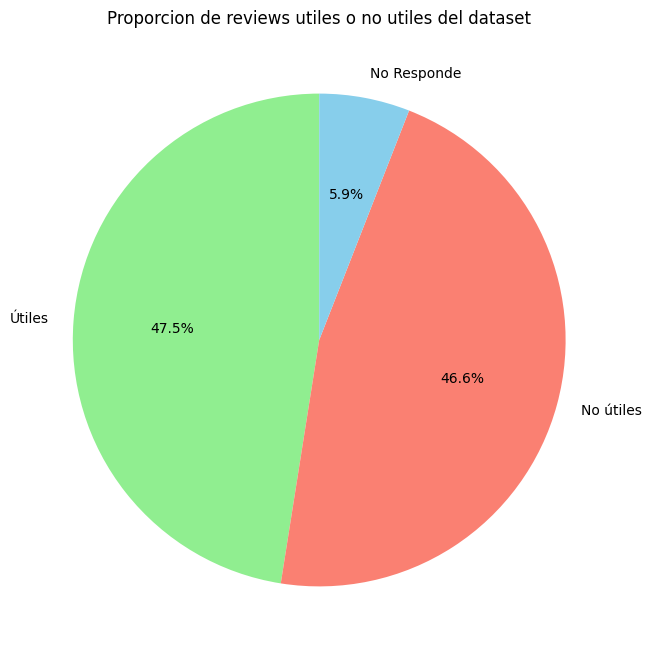

In [8]:
# Clasificamos los valores en util, no util y no responde.
df['Category'] = 'No Responde'
df.loc[df['HelpfulnessDenominator'] > 0, 'Category'] = 'No Util'
df.loc[df['HelpfulnessNumerator'] > 0, 'Category'] = 'Util'

# Contamos los valores de cada categoría
category_counts = df['Category'].value_counts()

# Calculamos la gráfica circular para mostrar la informacion relevante
labels = ['Útiles', 'No útiles', 'No Responde']
plt.figure(figsize=(8, 8))
plt.pie(category_counts, labels=labels, autopct='%1.1f%%', startangle=90, colors = ['lightgreen', 'salmon', 'skyblue'])
plt.title('Proporcion de reviews utiles o no utiles del dataset')
plt.show()


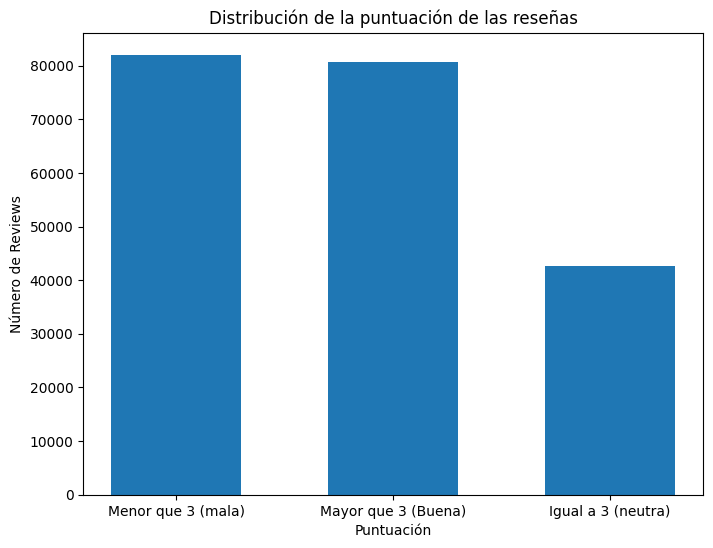

In [10]:
# Creamos categorías basadas en si la puntuacion es 3 (neutra), menor que 3 (mala),
# o superior a 3 (Buena opinión)
df['Score_level'] = pd.cut(
    df['Score'],
    bins=[0, 3, 4, 5],
    labels=['Menor que 3 (mala)', 'Igual a 3 (neutra)', 'Mayor que 3 (Buena)'],
    right=False
)

# Contamos los valores de cada categoría
score_counts = df['Score_level'].value_counts()

# Mostramos el histograma
plt.figure(figsize=(8, 6))
plt.bar(score_counts.index, score_counts.values, width=0.6)
plt.title('Distribución de la puntuación de las reseñas')
plt.xlabel('Puntuación')
plt.ylabel('Número de Reviews')
plt.show()

In [13]:
# Después de la exploración incial, dejamos el dataset como estaba
df.columns
df.drop(columns=['Category', 'Score_level'])

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...
...,...,...,...,...,...,...,...,...,...,...
568449,568450,B001EO7N10,A28KG5XORO54AY,Lettie D. Carter,0,0,5,1299628800,Will not do without,Great for sesame chicken..this is a good if no...
568450,568451,B003S1WTCU,A3I8AFVPEE8KI5,R. Sawyer,0,0,2,1331251200,disappointed,I'm disappointed with the flavor. The chocolat...
568451,568452,B004I613EE,A121AA1GQV751Z,"pksd ""pk_007""",2,2,5,1329782400,Perfect for our maltipoo,"These stars are small, so you can give 10-15 o..."
568452,568453,B004I613EE,A3IBEVCTXKNOH,"Kathy A. Welch ""katwel""",1,1,5,1331596800,Favorite Training and reward treat,These are the BEST treats for training and rew...


## **Obtención de una muestra del dataset original con el fin de poder trabajar con el entorno gratuito de Colab sin problemas de recursos**

In [ ]:
# Obtenemos el numero de productos con más reseñas
top_products = df['ProductId'].value_counts().reset_index()
top_products.columns = ['ProductId', 'Count']
top_products.head(250)

In [ ]:
# Obtenemos el número de productos distintos de todo el dataset
num_distinct_products = df['ProductId'].nunique()

num_distinct_products

In [ ]:
# Lista de los ProductId que deseamos obtener:
product_ids = top_products['ProductId'].head(250).tolist()

# Filtramos el DataFrame con los ProductId que deseamos obtener
df_patch = df[df['ProductId'].isin(product_ids)]

# Mostramos las primeras lineas del DataFrame filtrado
df_patch.head(10)

# Lo guardamos en un CSV
df_patch.to_csv('sample_reviews.csv', index=False, encoding='utf-8')

In [ ]:
# Forma de la muestra del dataset original de 568.000 filas para ser eficientes en el entorno gratuito
df_patch.shape

(86565, 10)

In [ ]:
print(df_patch['Score'].value_counts())

Score
5    51435
4    15347
3     8754
1     6103
2     4926
Name: count, dtype: int64


En este punto vemos que puede tener sentido balancear los datos pero generando SMOTE o upsampling. El razonamiento es porque si eliminamos muestras de la clase dominante, estamos eliminando tambien datos de la columna de las opiniones y por tanto, informacion bastante valiosa de cara al analisis NLP. Por tanto merece la pena aumentar el numero de muestras de las otras clases.

Lo vamos a hacer con negativo, positivo y neutro de forma que los positivos seran las opiniones con puntutacion 4 o 5, neutro seran las opiniones de tipo 3 y el resto de 1 o 2 seran negativas. por tanto debemos crear una feature que nos permita realizar este upsampling.

## **Carga del dataset con el 15% de los datos del dataset original, obtenido en el apartado anterior para trabajar en el proyecto**

In [ ]:
# preparación de librerias
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import spacy
import re # para expresiones regulares y eliminar ruido de las palabras
import inflect # para la conversion de numeros a su equivalente en palabra

### **Cargamos el dataset de la muestra tomada del dataset grande** ###

In [ ]:
df_sample = pd.read_csv('/content/sample_reviews.csv')

### **Eliminación de las variables que no intervienen en el estudio** ###


In [ ]:
# Seleccionamos las columnas que deseamos eliminar
columns_drop = ['Id', 'UserId', 'ProfileName', 'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Time']

# Eliminamos las columnas seleccionadas
df_tiny = df_sample.drop(columns=columns_drop)

# Mostramos el resultado para comprobar la eliminación
df_tiny.head()

,ProductId,Score,Summary,Text
0,B001RVFDOO,5,yummy,These chips are wonderful. My kids and I all ...
1,B001RVFDOO,5,Great Item,"Great packaging, and item is just as described..."
2,B001RVFDOO,5,Excellent chips,Just to give a little background - I ordered t...
3,B001RVFDOO,5,Perfect for WW followers,Got this item on a one-day-only sale on Amazon...
4,B001RVFDOO,5,"Variety pack, packed lunches",I discovered Pop Chips awhile back and fell in...


In [ ]:
df_tiny.shape

(86565, 4)

### **Transformacion de las variables textuales**

Primero cargamos el modelo para palabras en ingles

In [ ]:
# Cargamos el modelo de SpaCy para palabras en inglés puesto que los textos a transformar
# están en inglés
nlp = spacy.load('en_core_web_sm')

In [ ]:
# Creamos el motor de inflect
inflect_engine = inflect.engine()

# Convertir números a texto y limpiar caracteres especiales
df_tiny['Transformed_Summary'] = df_tiny['Summary'].apply(lambda text: re.sub(r'[^a-zA-Z\s]', '', ' '.join(
        inflect_engine.number_to_words(word) if word.isdigit() else word for word in text.split()
    )))
df_tiny['Transformed_Text'] = df_tiny['Text'].apply(lambda text: re.sub(r'[^a-zA-Z\s]', '', ' '.join(
        inflect_engine.number_to_words(word) if word.isdigit() else word for word in text.split()
    )))

# Convertimos a minúsculas, tokenizamos, eliminamos stopwords y lematizamos el texto
df_tiny['Transformed_Summary'] = df_tiny['Transformed_Summary'].apply(lambda text: " ".join(token.lemma_.lower()
        for token in nlp(text) if not token.is_stop and not token.is_punct))
df_tiny['Transformed_Text'] = df_tiny['Transformed_Text'].apply(
    lambda text: " ".join(token.lemma_.lower()
        for token in nlp(text) if not token.is_stop and not token.is_punct))

# Mostramos las primeras líneas para ver el resultado
df_tiny.head(30)

,ProductId,Score,Summary,Text,Transformed_Summary,Transformed_Text
0,B001RVFDOO,5,yummy,These chips are wonderful. My kids and I all ...,yummy,chip wonderful kid love salt pepperbr oz bag...
1,B001RVFDOO,5,Great Item,"Great packaging, and item is just as described...",great item,great packaging item describe purchase item sh...
2,B001RVFDOO,5,Excellent chips,Just to give a little background - I ordered t...,excellent chip,little background order great deal box singl...
3,B001RVFDOO,5,Perfect for WW followers,Got this item on a one-day-only sale on Amazon...,perfect ww follower,get item onedayonly sale amazon love have sing...
4,B001RVFDOO,5,"Variety pack, packed lunches",I discovered Pop Chips awhile back and fell in...,variety pack pack lunch,discover pop chips awhile fall love bbq flavor...
5,B001RVFDOO,4,Loved all the flavor except salt and pepper!,I really liked these chips as did my entire fa...,love flavor salt pepper,like chip entire family wish pick choose flavo...
6,B001RVFDOO,3,chips,These popchips were something I wanted to try ...,chip,popchip want try bake barbeque one okay rest t...
7,B001RVFDOO,4,Good as a sampler pack of the various flavors,"I like these Pop Chips a lot, but not all the ...",good sampler pack flavor,like pop chips lot flavor variety pack make go...
8,B001RVFDOO,5,These tastes pretty good,"These tastes good. If it's not fried, not bad ...",taste pretty good,taste good fry bad taste good eat course lot g...
9,B001RVFDOO,2,Didn't care for the variety selections,I bought two bags of PopChips at Whole Foods (...,not care variety selection,buy bag popchips foods original barbequeand lo...


In [ ]:
# Lo guardamos en un CSV el tokenizado para ahorrar recursos y cargar en una celda nueva
# este dataframe para evitar ejecutar tokenizaciones constantemente al hacer nuevos calculos
df_tiny.to_csv('tokenized_reviews.csv', index=False, encoding='utf-8')

## **Punto de carga del Dataset ya tokenizado del paso anterior para poder realizar los analisis univariante, bivariante...**

In [ ]:
# Cargamos el csv_tokenizado para ahorrar recursos
df_tokenized = pd.read_csv('/content/tokenized_reviews.csv')
df_tokenized.head(10)

,ProductId,Score,Summary,Text,Transformed_Summary,Transformed_Text
0,B001RVFDOO,5,yummy,These chips are wonderful. My kids and I all ...,yummy,chip wonderful kid love salt pepperbr oz bag...
1,B001RVFDOO,5,Great Item,"Great packaging, and item is just as described...",great item,great packaging item describe purchase item sh...
2,B001RVFDOO,5,Excellent chips,Just to give a little background - I ordered t...,excellent chip,little background order great deal box singl...
3,B001RVFDOO,5,Perfect for WW followers,Got this item on a one-day-only sale on Amazon...,perfect ww follower,get item onedayonly sale amazon love have sing...
4,B001RVFDOO,5,"Variety pack, packed lunches",I discovered Pop Chips awhile back and fell in...,variety pack pack lunch,discover pop chips awhile fall love bbq flavor...
5,B001RVFDOO,4,Loved all the flavor except salt and pepper!,I really liked these chips as did my entire fa...,love flavor salt pepper,like chip entire family wish pick choose flavo...
6,B001RVFDOO,3,chips,These popchips were something I wanted to try ...,chip,popchip want try bake barbeque one okay rest t...
7,B001RVFDOO,4,Good as a sampler pack of the various flavors,"I like these Pop Chips a lot, but not all the ...",good sampler pack flavor,like pop chips lot flavor variety pack make go...
8,B001RVFDOO,5,These tastes pretty good,"These tastes good. If it's not fried, not bad ...",taste pretty good,taste good fry bad taste good eat course lot g...
9,B001RVFDOO,2,Didn't care for the variety selections,I bought two bags of PopChips at Whole Foods (...,not care variety selection,buy bag popchips foods original barbequeand lo...


### **Analisis Univariante**

Lo primero es seleccionar las variables categoricas y numericas. Reutilizamos código que se usó en uno de los ejercicios entregables (módulo 7) para mayor comodidad. Además nos viene bien para obtener los estadisticos basicos de nuevo y tener una vision general de las variables

In [ ]:
numeric_columns = []
categoric_columns = []
for i,j in dict(df_tokenized.dtypes).items():
  if j == np.float64:
    numeric_columns.append([i, 'Cuantitativa continua', df_tokenized[i].mean(), df_tokenized[i].min(), df_tokenized[i].max(), df_tokenized[i].median()])
  elif j == np.int64:
    numeric_columns.append([i, 'Cuantitativa discreta', df_tokenized[i].mean(), df_tokenized[i].min(), df_tokenized[i].max(), df_tokenized[i].median()])
  else:
    categoric_columns.append([i, f'Cualitativa', df_tokenized[i].nunique()])

numeric_types = pd.DataFrame(numeric_columns, columns=['Nombre', 'Tipo de variable', 'Media', 'Mínimo', 'Máximo', 'Mediana'])
categoric_types = pd.DataFrame(categoric_columns, columns=['Nombre', 'Tipo de variable', 'Número de clases'])

print("Finalizado OK")

Finalizado OK


**Variables cualitativas**

In [ ]:
print(categoric_types.to_string())

                Nombre Tipo de variable  Número de clases
0            ProductId      Cualitativa               250
1              Summary      Cualitativa             30538
2                 Text      Cualitativa             36370
3  Transformed_Summary      Cualitativa             24062
4     Transformed_Text      Cualitativa             36350


**Calculamos estadisticas de las variables cualitativas**

In [ ]:
# Análisis univariante para 'ProductId', 'Summary' y 'Text'
# ProductId
print("Estadísticas ProductId:\n")
print("Valores únicos:", df_tokenized['ProductId'].nunique())
print("Valor más frecuente:", df_tokenized['ProductId'].mode()[0])
print("Frecuencia del valor más frecuente:", df_tokenized['ProductId'].value_counts().iloc[0])
print("\n")

# Summary
print("Estadísticas de Summary:\n")
print("Valores únicos:", df_tokenized['Summary'].nunique())
print("Longitud media (caracteres):", df_tokenized['Summary'].str.len().mean())
print("Mayor longitud (caracteres):", df_tokenized['Summary'].str.len().max())
print("Menor longitud (caracteres):", df_tokenized['Summary'].str.len().min())
print("\n")

# Text
print("Estadísticas de Text:\n")
print("Valores únicos:", df_tokenized['Text'].nunique())
print("Longitud media (caracteres):", df_tokenized['Text'].str.len().mean())
print("Mayor longitud (caracteres):", df_tokenized['Text'].str.len().max())
print("Menor longitud (caracteres):", df_tokenized['Text'].str.len().min())
print("\n")

# Transformed Summary
print("Estadísticas de Transformed_Summary:\n")
print("Valores únicos:", df_tokenized['Transformed_Summary'].nunique())
print("Longitud media (caracteres):", df_tokenized['Transformed_Summary'].str.len().mean())
print("Mayor longitud (caracteres):", df_tokenized['Transformed_Summary'].str.len().max())
print("Menor longitud (caracteres):", df_tokenized['Transformed_Summary'].str.len().min())
print("\n")

# Transformed Text
print("Estadísticas de Transformed_Text:\n")
print("Valores únicos:", df_tokenized['Transformed_Text'].nunique())
print("Longitud media (caracteres):", df_tokenized['Transformed_Text'].str.len().mean())
print("Mayor longitud (caracteres):", df_tokenized['Transformed_Text'].str.len().max())
print("Menor longitud (caracteres):", df_tokenized['Transformed_Text'].str.len().min())
print("\n")

Estadísticas ProductId:

Valores únicos: 250
Valor más frecuente: B007JFMH8M
Frecuencia del valor más frecuente: 913


Estadísticas de Summary:

Valores únicos: 30538
Longitud media (caracteres): 23.972124992779992
Mayor longitud (caracteres): 128
Menor longitud (caracteres): 2


Estadísticas de Text:

Valores únicos: 36370
Longitud media (caracteres): 475.6673944434818
Mayor longitud (caracteres): 21409
Menor longitud (caracteres): 18


Estadísticas de Transformed_Summary:

Valores únicos: 24062
Longitud media (caracteres): 17.107983617398972
Mayor longitud (caracteres): 109.0
Menor longitud (caracteres): 1.0


Estadísticas de Transformed_Text:

Valores únicos: 36350
Longitud media (caracteres): 250.58993819673077
Mayor longitud (caracteres): 13177
Menor longitud (caracteres): 9




**Visualizamos las variables cualitativas, para ver como se distribuyen los valores**

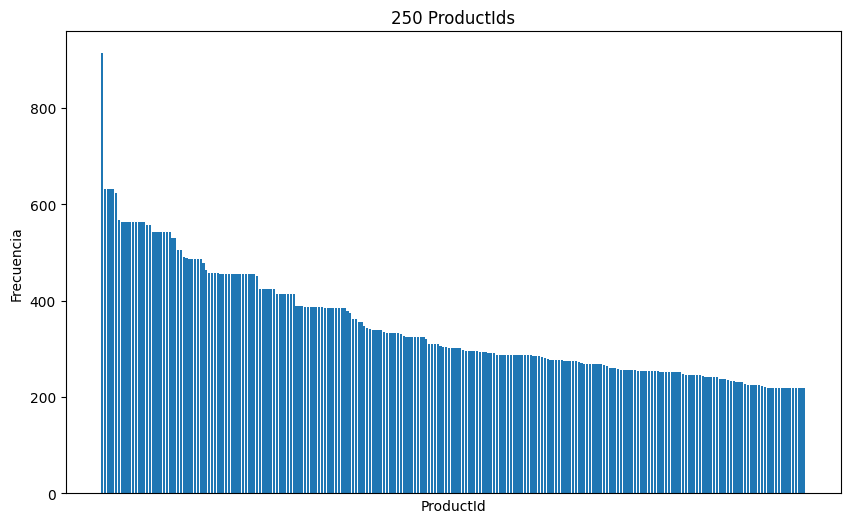

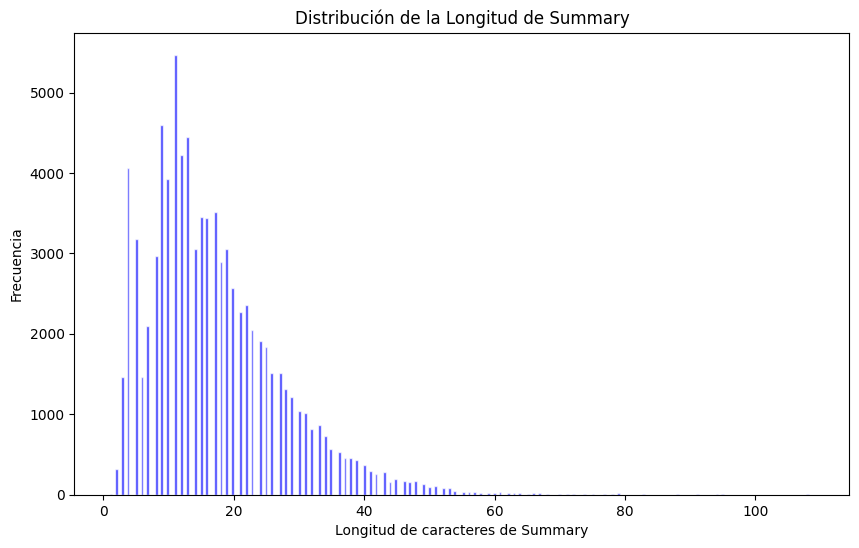

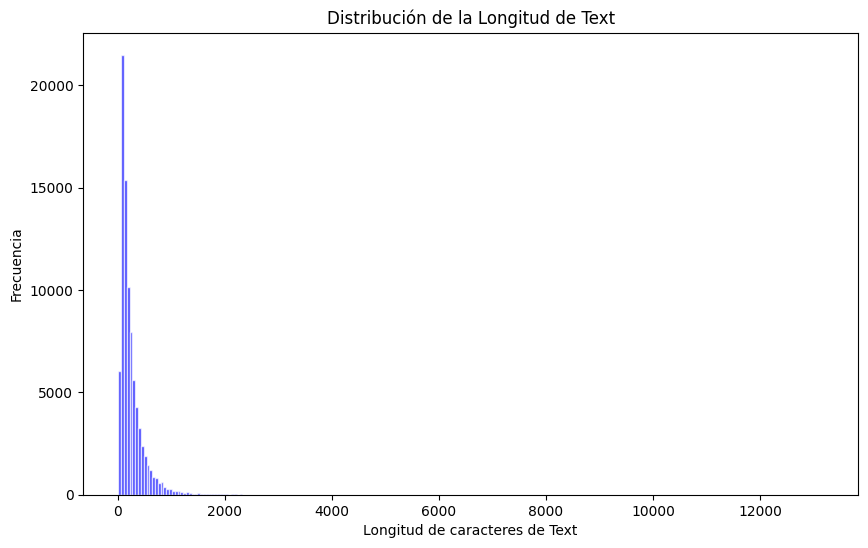

In [ ]:
# Visualización 1: Frecuencia de los valores más comunes de ProductId
top_product_ids = df_tokenized['ProductId'].value_counts().head(250)
plt.figure(figsize=(10, 6))
plt.bar(top_product_ids.index, top_product_ids.values)
plt.title('250 ProductIds')
plt.xlabel('ProductId')
plt.ylabel('Frecuencia')
plt.xticks([])
plt.show()

# Visualización 2: Distribución de la longitud de Summary
summary_lengths = df_tokenized['Transformed_Summary'].str.len()
plt.figure(figsize=(10, 6))
plt.hist(summary_lengths, bins=250, alpha=0.7, color='blue', edgecolor='white')
plt.title('Distribución de la Longitud de Summary')
plt.xlabel('Longitud de caracteres de Summary')
plt.ylabel('Frecuencia')
plt.show()

# Visualización 3: Distribución de la longitud de Text
text_lengths = df_tokenized['Transformed_Text'].str.len()
plt.figure(figsize=(10, 6))
plt.hist(text_lengths, bins=250, alpha=0.7, color='blue', edgecolor='white')
plt.title('Distribución de la Longitud de Text')
plt.xlabel('Longitud de caracteres de Text')
plt.ylabel('Frecuencia')
plt.show()

**Variables Cuantitativas**

In [ ]:
print(numeric_types.to_string())

  Nombre       Tipo de variable     Media  Mínimo  Máximo  Mediana
0  Score  Cuantitativa discreta  4.167735       1       5      5.0


**Visualizamos las variables cuantitativas para ver su distribución**

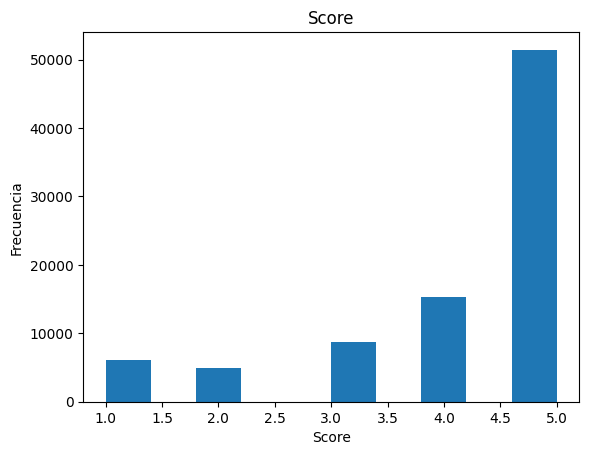

In [ ]:
for i in numeric_types.index:
    column = numeric_types['Nombre'][i]
    plt.hist(df_tokenized[column])
    plt.xlabel(column)
    plt.ylabel('Frecuencia')
    plt.title(column)
    plt.show()

**Análisis de la frecuencia de las palabras por puntuación**

Top palabras en la columna 'Summary':
[('great', 11681), ('good', 11036), ('coffee', 8606), ('love', 6092), ('taste', 5756), ('flavor', 3202), ('dog', 2850), ('delicious', 2810), ('like', 2805), ('product', 2787)]


Top palabras en la columna 'Text':
[('coffee', 62563), ('not', 54400), ('like', 53949), ('br', 51401), ('taste', 50299), ('good', 42991), ('flavor', 41548), ('try', 30564), ('love', 29683), ('great', 27326)]




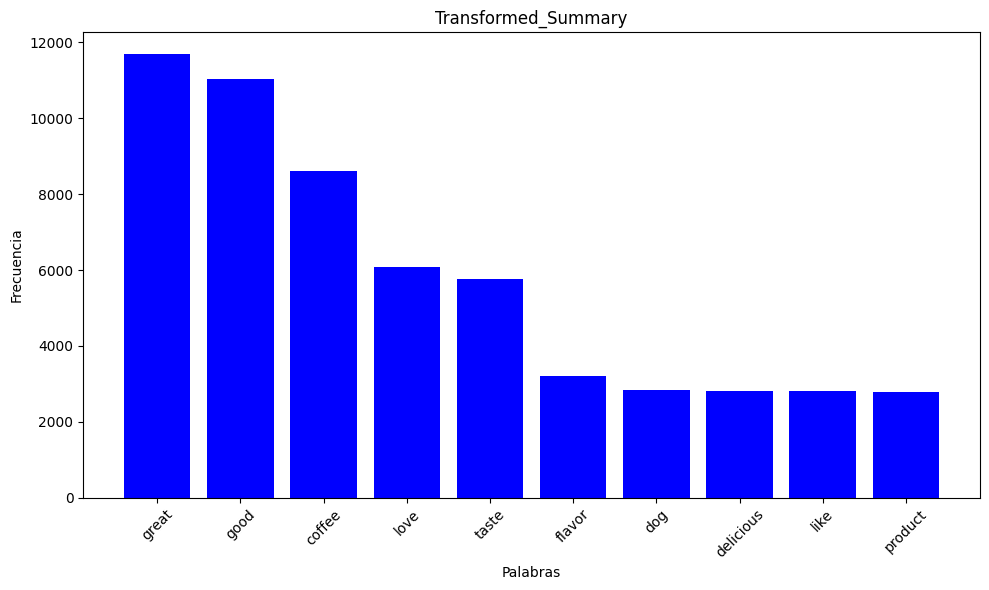

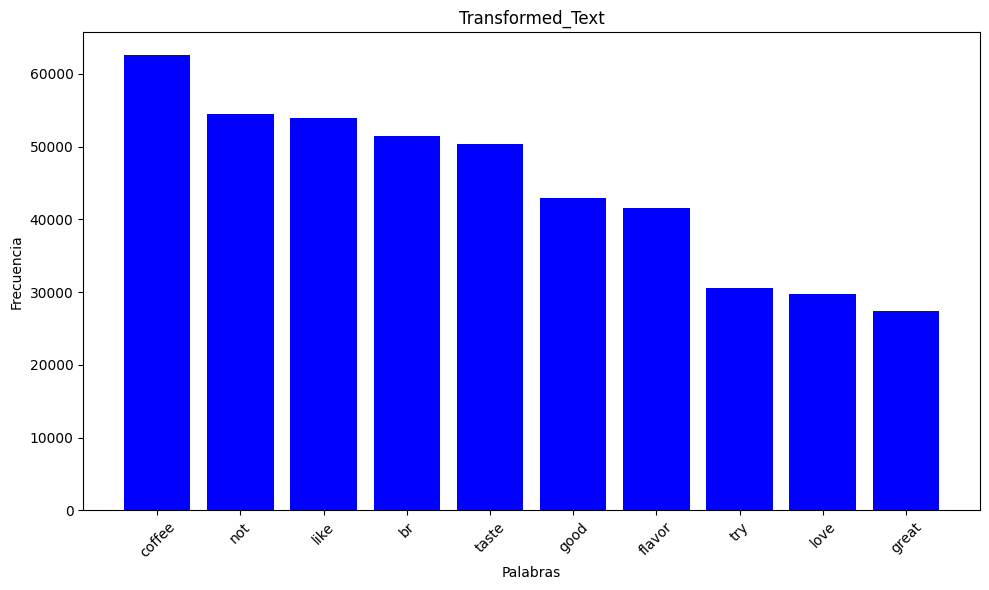

In [ ]:
# Diccionarios para almacenar las palabras más frecuentes de las dos columnas
frecuent_summary = {}
frecuent_text = {}

# Procesamos las columnas Transformed_Summary y Transformed_text
summaries = ' '.join(df_tokenized['Transformed_Summary'].dropna())
words_summary = summaries.lower().split()
word_counts_summary = Counter(words_summary)
frecuent_summary = word_counts_summary.most_common(10)

texts = ' '.join(df_tokenized['Transformed_Text'].dropna())
words_text = texts.lower().split()
word_counts_text = Counter(words_text)
frecuent_text = word_counts_text.most_common(10)

# Mostramos las palabras más frecuentes
print("Top palabras en la columna 'Summary':")
print(frecuent_summary)
print("\n")

print("Top palabras en la columna 'Text':")
print(frecuent_text)
print("\n")

# Transformed_Summary
# Creamos listas de palabras y frecuencias para mostrarlas en un histograma
words = [item[0] for item in frecuent_summary]
counts = [item[1] for item in frecuent_summary]

# Creamos el histograma para Summary
plt.figure(figsize=(10, 6))
plt.bar(words, counts, color='blue')
plt.title("Transformed_Summary")
plt.xlabel("Palabras")
plt.ylabel("Frecuencia")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Transformed_Text
# Creamos listas de palabras y frecuencias para mostrarlas en un histograma
words = [item[0] for item in frecuent_text]
counts = [item[1] for item in frecuent_text]

# Creamos el histograma para Summary
plt.figure(figsize=(10, 6))
plt.bar(words, counts, color='blue')
plt.title("Transformed_Text")
plt.xlabel("Palabras")
plt.ylabel("Frecuencia")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### **Análisis Bivariante**

**Distribución de texto frente a ProductId**

Estadísticos Text vs ProductId:

      ProductId  Mean_Text  Median_text  Max_text  Min_text  Std_Dev_text
0    B0001ES9F8  26.260417         21.0       121         1     18.786483
1    B0007A0AQM  32.476415         23.0       308         5     29.961747
2    B0007A0AQW  32.476415         23.0       308         5     29.961747
3    B0009F3POY  42.397260         29.0       317         7     40.098184
4    B0009YJ4CW  53.712062         43.0       231         8     38.653039
..          ...        ...          ...       ...       ...           ...
245  B008RWUKXK  63.016949         50.0       322         8     49.258271
246  B008ZRKZSM  36.606452         28.0       462         7     36.181312
247  B0090X8IPM  59.024528         47.0       377         8     43.863482
248  B009E7YC54  37.445378         26.0       271         7     33.025293
249  B009RB4GO4  26.653386         20.0       113         6     20.544863

[250 rows x 6 columns]


Estadísticos Summary vs ProductId:

      ProductId  

<Figure size 1400x600 with 0 Axes>

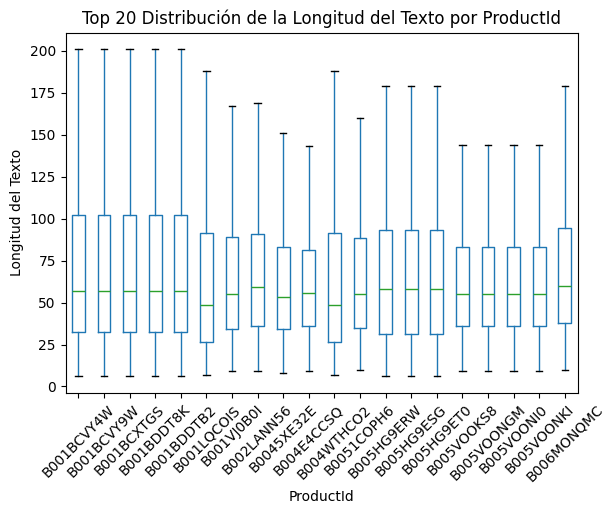

<Figure size 1800x600 with 0 Axes>

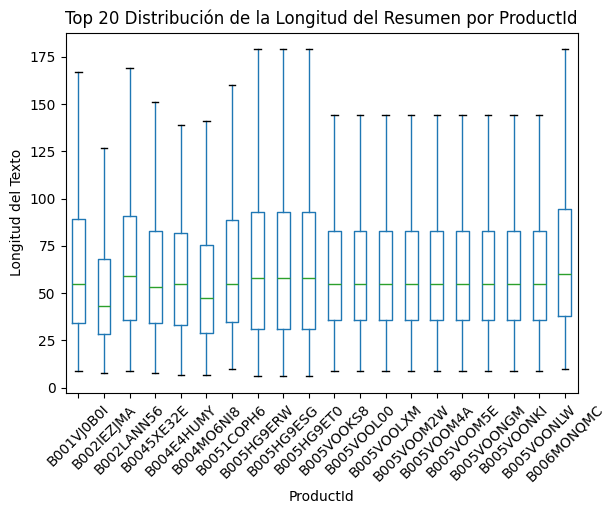

In [ ]:
# Creamos una columna con la longitud de Transformed_Text y Transformed_Summary para cada fila
df_tokenized['Text_Length'] = df_tokenized['Transformed_Text'].apply(lambda x: len(str(x).split()))
df_tokenized['Summary_Length'] = df_tokenized['Transformed_Summary'].apply(lambda y: len(str(y).split()))

# Agrupamos por ProductId y calculamos estadísticas basicas para la longitud de texto
productId_text = df_tokenized.groupby('ProductId')['Text_Length'].agg(Mean_Text='mean',Median_text='median',Max_text='max',Min_text='min',Std_Dev_text='std').reset_index()
productId_summary = df_tokenized.groupby('ProductId')['Summary_Length'].agg(Mean_Sum='mean',Median_Sum='median',Max_Sum='max',Min_Sum='min',Std_Dev_Sum='std').reset_index()

# Mostramos resultados
print("Estadísticos Text vs ProductId:\n")
print(productId_text)
print("\n")
print("Estadísticos Summary vs ProductId:\n")
print(productId_summary)
print("\n")

# Mostramos graficas de los resultados para los 20 primeros productos en orden descendete.
product_text_analysis_sorted_Text = productId_text.sort_values(by='Mean_Text', ascending=False).head(20)
product_text_analysis_sorted_Summary = productId_summary.sort_values(by='Mean_Sum', ascending=False).head(20)

# Text vs. ProductId
# Boxplot para la longitud del texto agrupada por los 10 productos más frecuentes
top_10_products = product_text_analysis_sorted_Text['ProductId']
filtered_df = df_tokenized[df_tokenized['ProductId'].isin(top_10_products)]

plt.figure(figsize=(14, 6))
filtered_df.boxplot(column='Text_Length', by='ProductId', grid=False, showfliers=False)
plt.title('Top 20 Distribución de la Longitud del Texto por ProductId')
plt.suptitle('')  # Quitar el título por defecto del boxplot
plt.xlabel('ProductId')
plt.ylabel('Longitud del Texto')
plt.xticks(rotation=45)
plt.show()

# Summary vs. ProductId
# Boxplot para la longitud del resumen agrupada por los 20 productos más frecuentes
top_10_products = product_text_analysis_sorted_Summary['ProductId']
filtered_df = df_tokenized[df_tokenized['ProductId'].isin(top_10_products)]

plt.figure(figsize=(18, 6))
filtered_df.boxplot(column='Text_Length', by='ProductId', grid=False, showfliers=False)
plt.title('Top 20 Distribución de la Longitud del Resumen por ProductId')
plt.suptitle('')
plt.xlabel('ProductId')
plt.ylabel('Longitud del Texto')
plt.xticks(rotation=45)
plt.show()

**Análisis ProductId vs. Score**

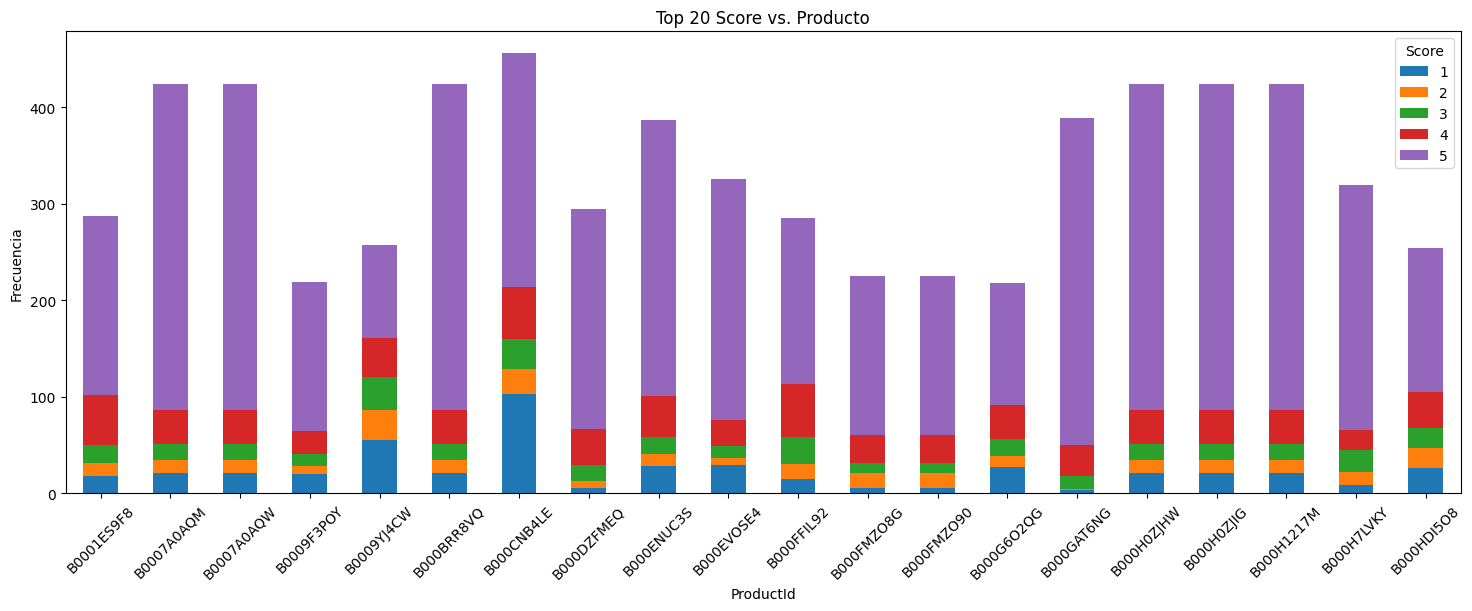

In [ ]:
# seleccionamos los 20 productos top
score_products = df_tokenized.groupby(['ProductId', 'Score']).size().unstack(fill_value=0)

# Graficamos los resultados, superponiendo gráficas por puntuación
score_products.head(20).plot(kind='bar', figsize=(18, 6), stacked=True)
plt.title('Top 20 Score vs. Producto')
plt.xlabel('ProductId')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)
plt.legend(title='Score')
plt.show()

**Frecuecia de las palabras de los textos vs. Score**


 Palabras más comunes por puntuacion en resumenes:

{1: [('taste', 623), ('coffee', 429), ('not', 408), ('bad', 339), ('like', 293), ('good', 232), ('horrible', 210), ('flavor', 187), ('dog', 176), ('buy', 154)], 2: [('taste', 537), ('good', 365), ('coffee', 343), ('not', 313), ('like', 297), ('flavor', 297), ('great', 195), ('weak', 176), ('dog', 163), ('bad', 134)], 3: [('good', 1250), ('taste', 884), ('coffee', 723), ('great', 530), ('flavor', 530), ('ok', 504), ('like', 449), ('not', 410), ('bad', 310), ('love', 300)], 4: [('good', 3312), ('coffee', 1860), ('great', 1727), ('taste', 1274), ('flavor', 803), ('tasty', 746), ('love', 740), ('like', 723), ('nice', 579), ('dog', 497)], 5: [('great', 9114), ('good', 5877), ('coffee', 5251), ('love', 4943), ('taste', 2438), ('delicious', 2367), ('product', 2022), ('dog', 1731), ('yummy', 1517), ('excellent', 1454)]}

 Palabras más comunes por puntuacion en textos:

{1: [('not', 4625), ('taste', 4291), ('coffee', 4030), ('like', 3766), ('

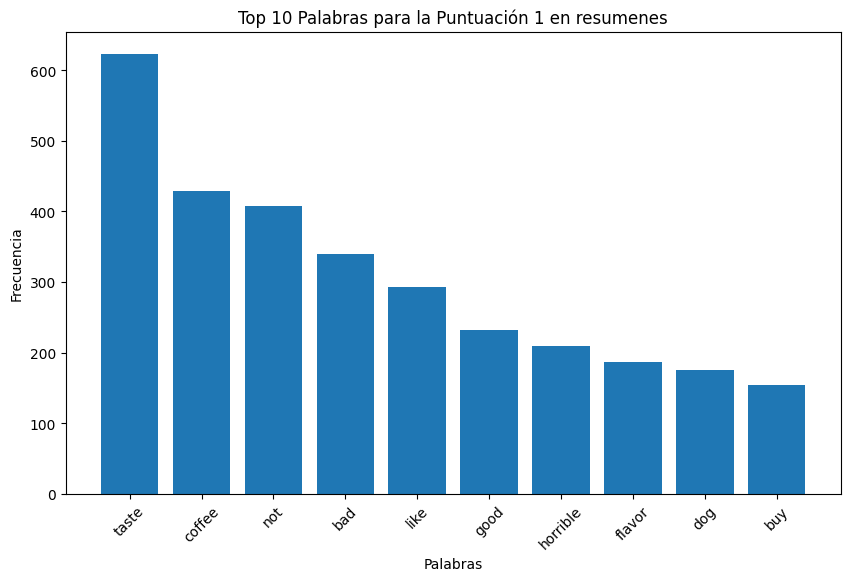

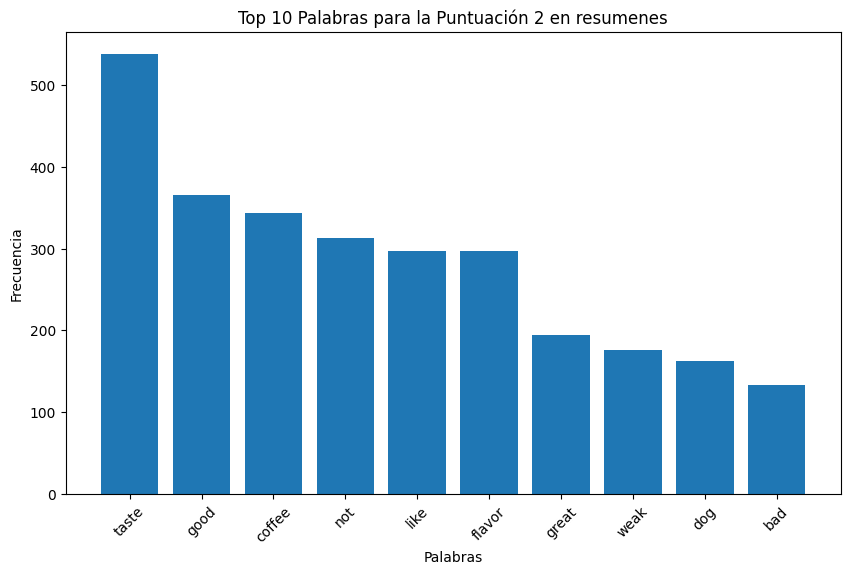

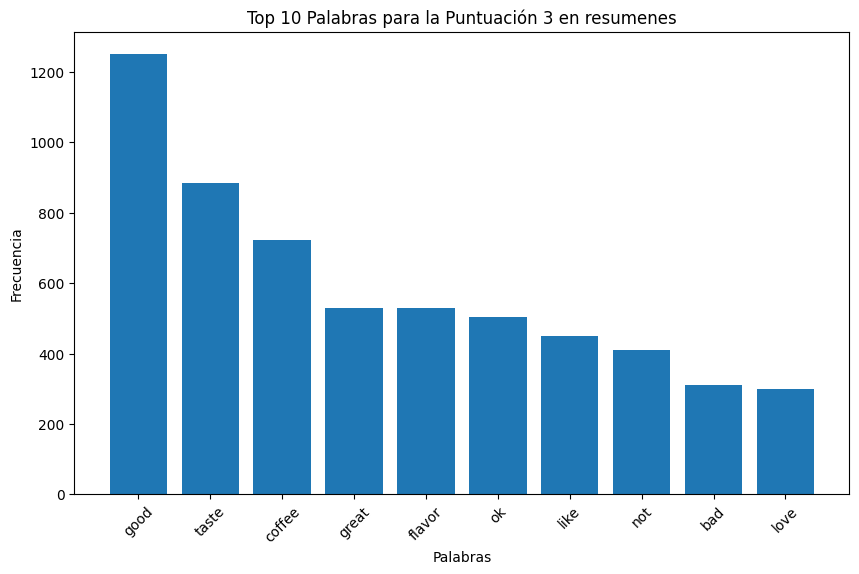

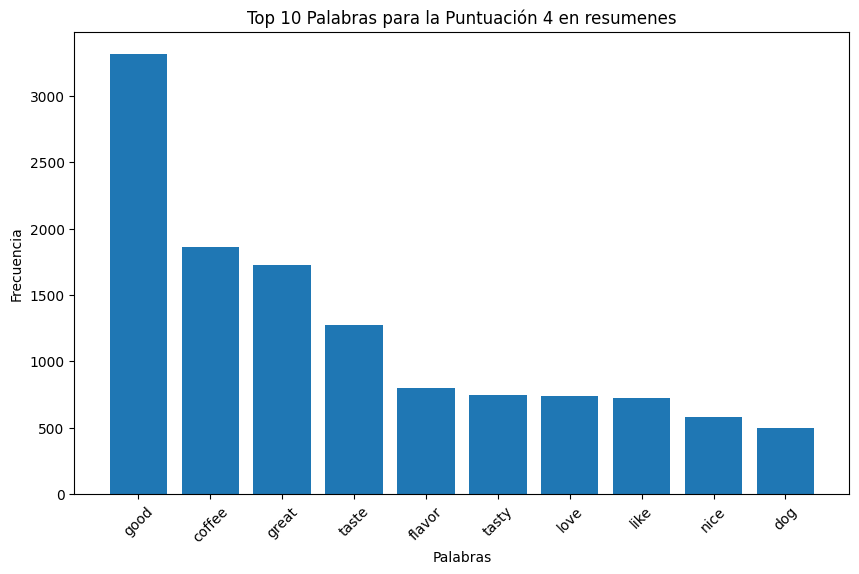

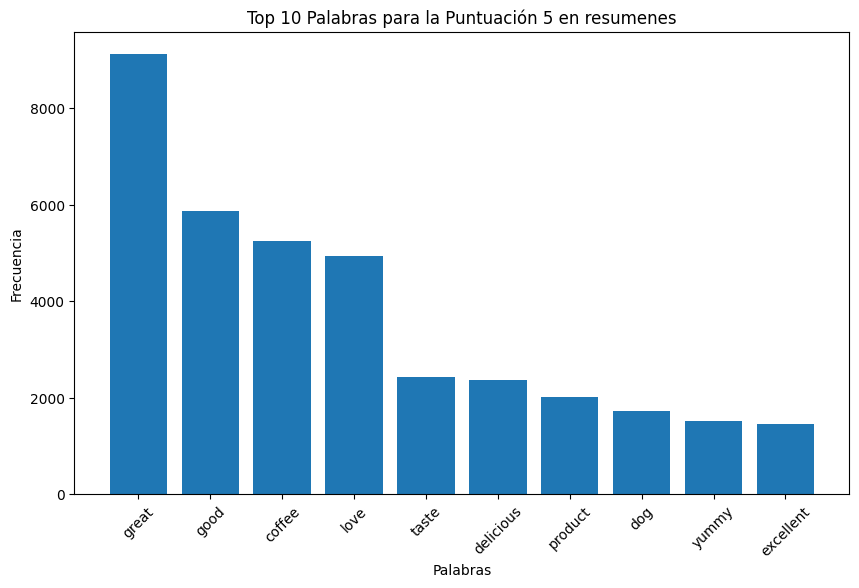

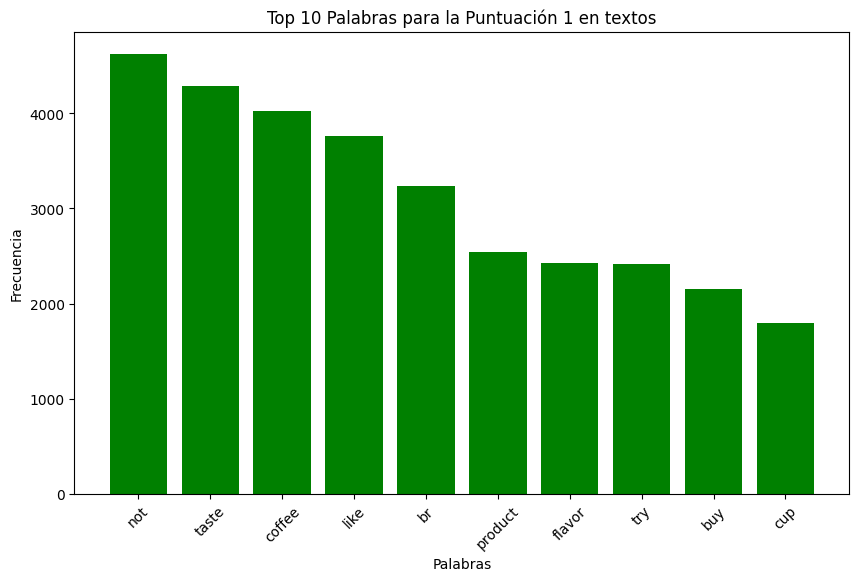

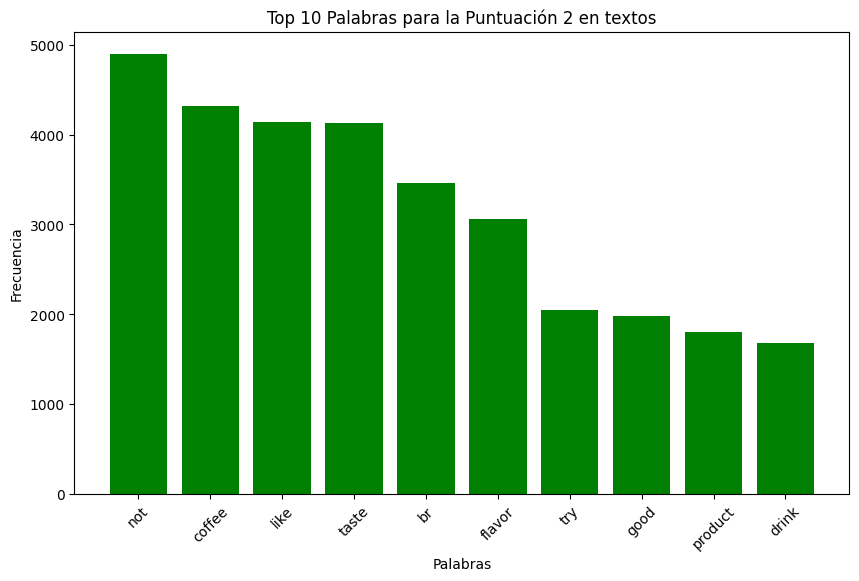

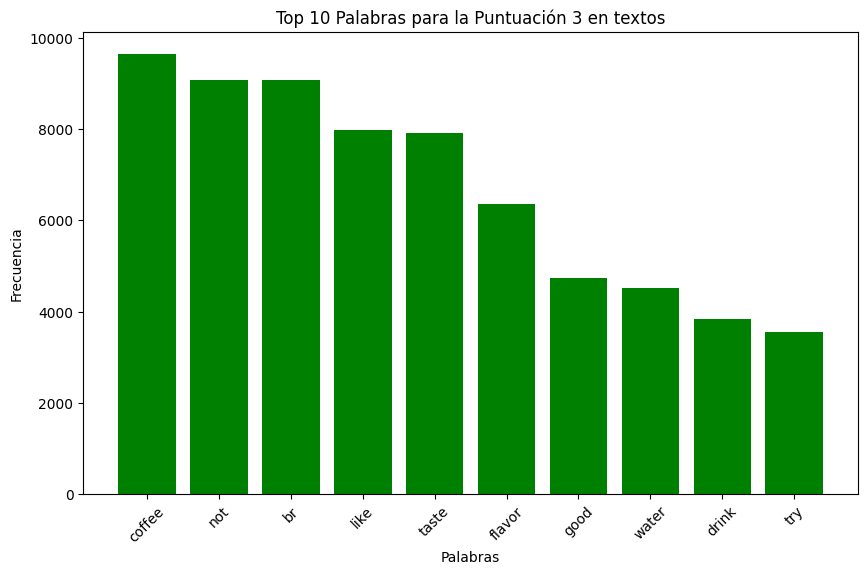

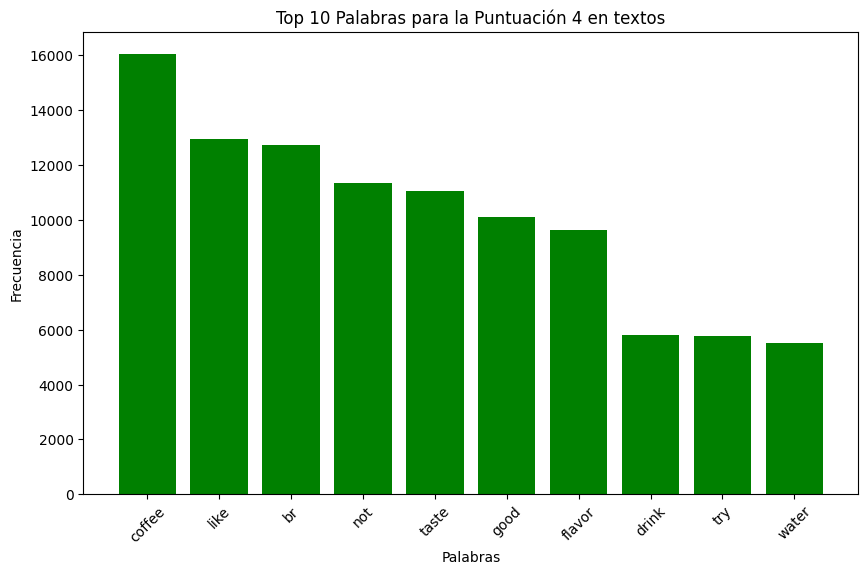

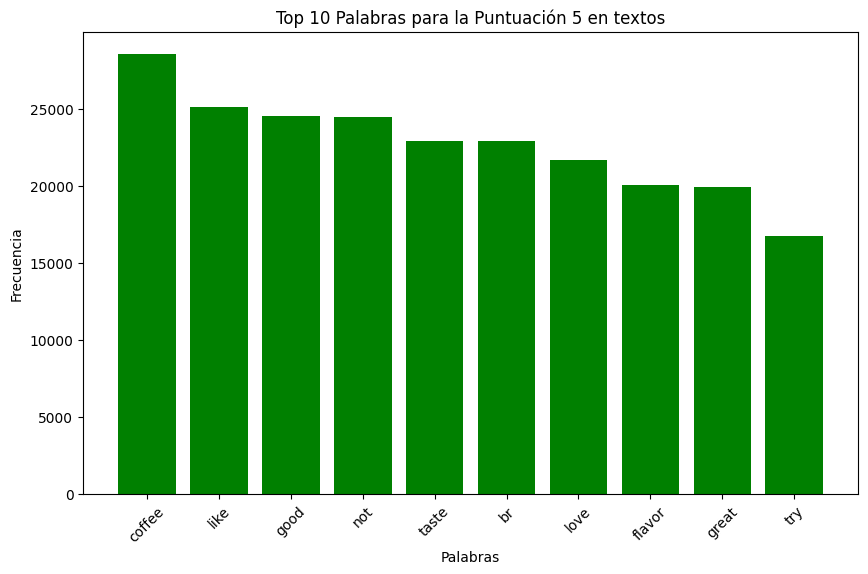

In [ ]:
# Diccionarios para almacenar las palabras más frecuentes por puntuación
top_words_by_score_summary = {}
top_words_by_score_text = {}

# Agrupamos por la columna Score
for score, group in df_tokenized.groupby('Score'):
    # Combinamos todas las filas de la columna 'Transformed_Summary' evitando los valores faltantes
    summaries = ' '.join(group['Transformed_Summary'].dropna())
    # Convertimos a minúsculas y tokenizamos
    words_summaries = summaries.lower().split()
    # Contamos las palabras
    word_counts_summary = Counter(words_summaries)
    # Obtenemos las 10 palabras más comunes para esta puntuación
    top_words_by_score_summary[score] = word_counts_summary.most_common(10)

    # Combinamos todas las filas de la columna 'Transformed_Text' evitando los valores faltantes
    texts = ' '.join(group['Transformed_Text'].dropna())
    # Convertimos a minúsculas y tokenizamos
    words_texts = texts.lower().split()
    # Contamos las palabras
    word_counts_text = Counter(words_texts)
    # Obtenemos las 10 palabras más comunes para esta puntuación
    top_words_by_score_text[score] = word_counts_text.most_common(10)

# Mostramos el result
print("\n Palabras más comunes por puntuacion en resumenes:\n")
print(top_words_by_score_summary)
print("\n Palabras más comunes por puntuacion en textos:\n")
print(top_words_by_score_text)

# Mostramos histograma para ver como salen las frecuencias de las palabras
for score in top_words_by_score_summary:
    word_freq = dict(top_words_by_score_summary[score])
    plt.figure(figsize=(10, 6))
    plt.bar(word_freq.keys(), word_freq.values())
    plt.title(f"Top 10 Palabras para la Puntuación {score} en resumenes")
    plt.xlabel('Palabras')
    plt.ylabel('Frecuencia')
    plt.xticks(rotation=45)
    plt.show()

for score in top_words_by_score_text:
    word_freq = dict(top_words_by_score_text[score])
    plt.figure(figsize=(10, 6))
    plt.bar(word_freq.keys(), word_freq.values(), color="green")
    plt.title(f"Top 10 Palabras para la Puntuación {score} en textos")
    plt.xlabel('Palabras')
    plt.ylabel('Frecuencia')
    plt.xticks(rotation=45)
    plt.show()

**Cálculo de la similaridad de coseno entre Summary y text**


In [ ]:
# Seleccionamos una muestra de datos para el análisis
sample_data = df_tokenized[['Transformed_Text', 'Transformed_Summary']].dropna().sample(n=df_tokenized.shape[0], replace=True, random_state=42)

# Vectorización TF-IDF para la similitud del coseno
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(sample_data['Transformed_Text'] + sample_data['Transformed_Summary'])

# Calculamos la similitud del coseno
cosine_similarities = []

for rr, row in sample_data.iterrows():
    tfidf_text = tfidf_vectorizer.transform([row['Transformed_Text']])
    tfidf_summary = tfidf_vectorizer.transform([row['Transformed_Summary']])

    # Cosine similarity
    cosine_sim = cosine_similarity(tfidf_text, tfidf_summary)[0][0]
    cosine_similarities.append(cosine_sim)

# Añadimos los resultados al dataframe
sample_data['Cosine_Similarity'] = cosine_similarities


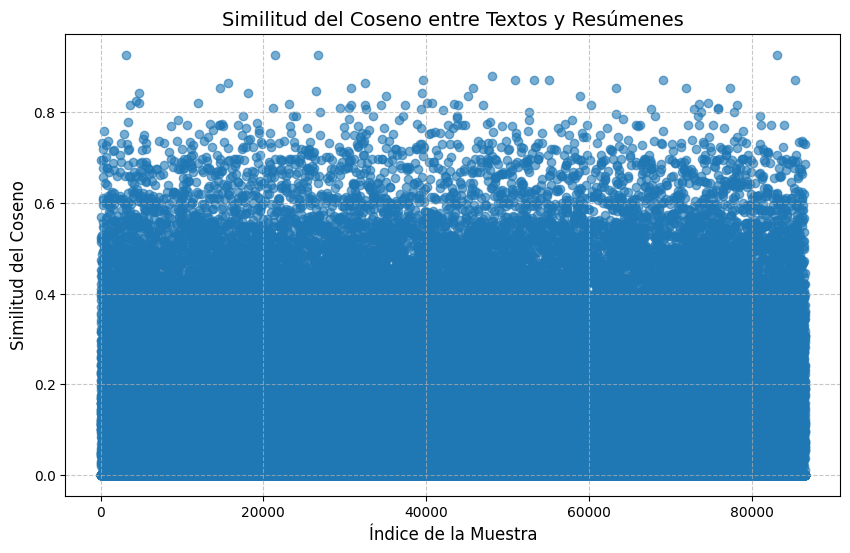

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(range(len(sample_data)), sample_data['Cosine_Similarity'], alpha=0.6)
plt.title('Similitud del Coseno entre Textos y Resúmenes', fontsize=14)
plt.xlabel('Índice de la Muestra', fontsize=12)
plt.ylabel('Similitud del Coseno', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

In [ ]:
# Calculamos el sentimiento para ambas columnas
df_tokenized['Sentiment_Text'] = df_tokenized['Transformed_Text'].apply(lambda text: TextBlob(str(text)).sentiment.polarity)
df_tokenized['Sentiment_Summary'] = df_tokenized['Transformed_Summary'].apply(lambda text: TextBlob(str(text)).sentiment.polarity)

# Calculamos la correlación entre los sentimientos
correlation = df_tokenized['Sentiment_Text'].corr(df_tokenized['Sentiment_Summary'])

# Mostramos los resultados
print("Correlación entre los sentimientos de texto y resumen:" + str(correlation))

Correlación entre los sentimientos de texto y resumen:0.2725784021783495


**Eliminamos las columnas de texto y resumen sin tokenizar, ya que no va a hacer falta en la fase de modelaje, asi como las creadas para el analisis de los datos ya que no serán necesarias tampoco en el modelaje. Por tanto nos quedaremos unicamente con 4 columnas, Score, ProductId, Transformed_text y Transformed_Summary**

In [ ]:
df_tokenized.head()

,ProductId,Score,Summary,Text,Transformed_Summary,Transformed_Text,Text_Length,Summary_Length,Sentiment_Text,Sentiment_Summary
0,B001RVFDOO,5,yummy,These chips are wonderful. My kids and I all ...,yummy,chip wonderful kid love salt pepperbr oz bag...,13,1,0.750000,0.0
1,B001RVFDOO,5,Great Item,"Great packaging, and item is just as described...",great item,great packaging item describe purchase item sh...,9,2,0.500000,0.8
2,B001RVFDOO,5,Excellent chips,Just to give a little background - I ordered t...,excellent chip,little background order great deal box singl...,43,2,0.148006,1.0
3,B001RVFDOO,5,Perfect for WW followers,Got this item on a one-day-only sale on Amazon...,perfect ww follower,get item onedayonly sale amazon love have sing...,28,3,0.489286,1.0
4,B001RVFDOO,5,"Variety pack, packed lunches",I discovered Pop Chips awhile back and fell in...,variety pack pack lunch,discover pop chips awhile fall love bbq flavor...,70,4,0.288095,0.0


**Eliminamos las variables creadas para graficar que no son de utilidad y pueden crear problemas en el dataset**

In [ ]:
columns = ['Summary', 'Text', 'Text_Length', 'Summary_Length', 'Sentiment_Text', 'Sentiment_Summary']
df_modeling = df_tokenized.drop(columns=columns)
df_modeling.head()

,ProductId,Score,Transformed_Summary,Transformed_Text
0,B001RVFDOO,5,yummy,chip wonderful kid love salt pepperbr oz bag...
1,B001RVFDOO,5,great item,great packaging item describe purchase item sh...
2,B001RVFDOO,5,excellent chip,little background order great deal box singl...
3,B001RVFDOO,5,perfect ww follower,get item onedayonly sale amazon love have sing...
4,B001RVFDOO,5,variety pack pack lunch,discover pop chips awhile fall love bbq flavor...


In [ ]:
# Lo guardamos en un CSV el tokenizado para ahorrar recursos y cargar en una celda nueva
# este dataframe para evitar ejecutar tokenizaciones constantemente al hacer nuevos calculos
df_modeling.to_csv('modeling_reviews.csv', index=False, encoding='utf-8')

## **Nuevo punto de almacenamiento y carga de datos para continuar el analisis desde este punto**

In [ ]:
# preparación de librerias
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import spacy
import re # para expresiones regulares y eliminar ruido de las palabras
import inflect # para la conversion de numeros a su equivalente en palabra
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from textblob import TextBlob

In [ ]:
# Cargamos el csv_modelado
df_modeling_patch = pd.read_csv('/content/modeling_reviews.csv')
df_modeling_patch.head(10)

,ProductId,Score,Transformed_Summary,Transformed_Text
0,B001RVFDOO,5,yummy,chip wonderful kid love salt pepperbr oz bag...
1,B001RVFDOO,5,great item,great packaging item describe purchase item sh...
2,B001RVFDOO,5,excellent chip,little background order great deal box singl...
3,B001RVFDOO,5,perfect ww follower,get item onedayonly sale amazon love have sing...
4,B001RVFDOO,5,variety pack pack lunch,discover pop chips awhile fall love bbq flavor...
5,B001RVFDOO,4,love flavor salt pepper,like chip entire family wish pick choose flavo...
6,B001RVFDOO,3,chip,popchip want try bake barbeque one okay rest t...
7,B001RVFDOO,4,good sampler pack flavor,like pop chips lot flavor variety pack make go...
8,B001RVFDOO,5,taste pretty good,taste good fry bad taste good eat course lot g...
9,B001RVFDOO,2,not care variety selection,buy bag popchips foods original barbequeand lo...


**Deteccion de valores faltantes**

In [ ]:
# Buscamos valores faltantes
columns_to_check = ['ProductId', 'Score', 'Transformed_Text', 'Transformed_Summary']

# Hacemos bucle para buscar sobre las columnas sobre las columnas y calcular valores faltantes
print("Valores faltantes:\n")
for column in columns_to_check:
    missing_values = df_modeling_patch[column].isnull().sum()
    print(f"{column}: {missing_values}")

Valores faltantes:

ProductId: 0
Score: 0
Transformed_Text: 0
Transformed_Summary: 376


**Analizamos los valores atípicos de las variables cuantitativas**

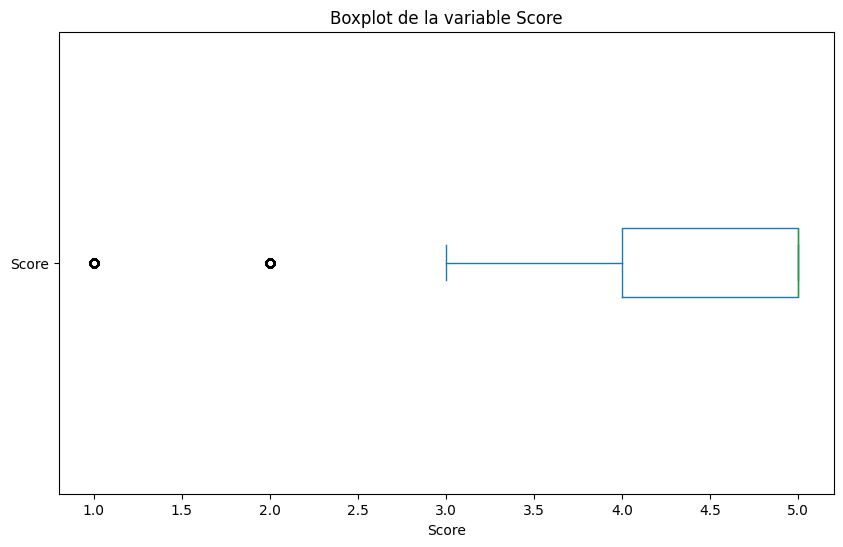

In [ ]:
plt.figure(figsize=(10, 6))
df['Score'].plot(kind='box', vert=False)
plt.title('Boxplot de la variable Score')
plt.xlabel('Score')
plt.show()

**Concatenación de las columnas de texto y resumen y eliminacion de las columnas que no hacen falta una vez concatenadas**

In [ ]:
# Concatenamos las columnas Transformed_Text y Transformed_Summary. se usa fillna para sustituir
# los valores nulos por cadenas vacias
df_modeling_patch['Review'] = df_modeling_patch['Transformed_Summary'].fillna('') + " " + df_modeling_patch['Transformed_Text'].fillna('')
df_modeling_patch.head()

,ProductId,Score,Transformed_Summary,Transformed_Text,Review
0,B001RVFDOO,5,yummy,chip wonderful kid love salt pepperbr oz bag...,yummy chip wonderful kid love salt pepperbr ...
1,B001RVFDOO,5,great item,great packaging item describe purchase item sh...,great item great packaging item describe purch...
2,B001RVFDOO,5,excellent chip,little background order great deal box singl...,excellent chip little background order great...
3,B001RVFDOO,5,perfect ww follower,get item onedayonly sale amazon love have sing...,perfect ww follower get item onedayonly sale a...
4,B001RVFDOO,5,variety pack pack lunch,discover pop chips awhile fall love bbq flavor...,variety pack pack lunch discover pop chips awh...


In [ ]:
# Eliminamos las columnas de Texto y Resumen, una vez estan ya concatenadas
df_modeling_patch.drop(['Transformed_Text', 'Transformed_Summary'], axis=1, inplace=True)
df_modeling_patch.head()

,ProductId,Score,Review
0,B001RVFDOO,5,yummy chip wonderful kid love salt pepperbr ...
1,B001RVFDOO,5,great item great packaging item describe purch...
2,B001RVFDOO,5,excellent chip little background order great...
3,B001RVFDOO,5,perfect ww follower get item onedayonly sale a...
4,B001RVFDOO,5,variety pack pack lunch discover pop chips awh...


**Creación de feature para agrupar reseñas por tipos de puntuación**

In [ ]:
# Creamos la nueva feature a partir de Score para clasificar en buenas o malas las reseñas.
df_modeling_patch['Label'] = df_modeling_patch['Score'].apply(lambda x: 'negative' if x in [1, 2] else ('neutral' if x == 3 else 'positive'))

# Reordenamos las columnas para que la nueva columna aparezca antes de 'Score'
columns = list(df_modeling_patch.columns)
columns.remove('Label')
columns.insert(columns.index('Score'), 'Label')
df_modeling_patch = df_modeling_patch[columns]
df_modeling_patch.head(40)

,ProductId,Label,Score,Review
0,B001RVFDOO,positive,5,yummy chip wonderful kid love salt pepperbr ...
1,B001RVFDOO,positive,5,great item great packaging item describe purch...
2,B001RVFDOO,positive,5,excellent chip little background order great...
3,B001RVFDOO,positive,5,perfect ww follower get item onedayonly sale a...
4,B001RVFDOO,positive,5,variety pack pack lunch discover pop chips awh...
5,B001RVFDOO,positive,4,love flavor salt pepper like chip entire famil...
6,B001RVFDOO,neutral,3,chip popchip want try bake barbeque one okay r...
7,B001RVFDOO,positive,4,good sampler pack flavor like pop chips lot fl...
8,B001RVFDOO,positive,5,taste pretty good taste good fry bad taste goo...
9,B001RVFDOO,negative,2,not care variety selection buy bag popchips fo...


In [ ]:
print("Distribución antes de SMOTE:")
print(df_modeling_patch['Score'].value_counts())

Distribución antes de SMOTE:
Score
5    51435
4    15347
3     8754
1     6103
2     4926
Name: count, dtype: int64


In [ ]:
# Eliminamos la columna Score, una vez estan ya hemos creado la feature
df_modeling_patch.drop(['Score'], axis=1, inplace=True)
df_modeling_patch.head()


,ProductId,Label,Review
0,B001RVFDOO,positive,yummy chip wonderful kid love salt pepperbr ...
1,B001RVFDOO,positive,great item great packaging item describe purch...
2,B001RVFDOO,positive,excellent chip little background order great...
3,B001RVFDOO,positive,perfect ww follower get item onedayonly sale a...
4,B001RVFDOO,positive,variety pack pack lunch discover pop chips awh...


In [ ]:

# Lo guardamos en un CSV el tokenizado para ahorrar recursos y cargar en una celda nueva
# este dataframe para evitar ejecutar tokenizaciones constantemente al hacer nuevos calculos
df_modeling_patch.to_csv('clean_reviews.csv', index=False, encoding='utf-8')


NameError: name 'df_modeling_patch' is not defined

## **Nuevo punto de carga de datos, en este caso con el dataset ya preparado para hacer el balanceo de clases**

In [ ]:
# preparación de librerias
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import spacy
import re # para expresiones regulares y eliminar ruido de las palabras
import inflect # para la conversion de numeros a su equivalente en palabra
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from textblob import TextBlob

In [ ]:
# Cargamos el csv_modelado
df_SMOTE = pd.read_csv('/content/clean_reviews.csv')
df_SMOTE.head(10)

,ProductId,Label,Review
0,B001RVFDOO,positive,yummy chip wonderful kid love salt pepperbr ...
1,B001RVFDOO,positive,great item great packaging item describe purch...
2,B001RVFDOO,positive,excellent chip little background order great...
3,B001RVFDOO,positive,perfect ww follower get item onedayonly sale a...
4,B001RVFDOO,positive,variety pack pack lunch discover pop chips awh...
5,B001RVFDOO,positive,love flavor salt pepper like chip entire famil...
6,B001RVFDOO,neutral,chip popchip want try bake barbeque one okay r...
7,B001RVFDOO,positive,good sampler pack flavor like pop chips lot fl...
8,B001RVFDOO,positive,taste pretty good taste good fry bad taste goo...
9,B001RVFDOO,negative,not care variety selection buy bag popchips fo...


In [ ]:
print("Distribución antes de SMOTE:")
print(df_SMOTE['Label'].value_counts())

Distribución antes de SMOTE:
Label
positive    66782
negative    11029
neutral      8754
Name: count, dtype: int64


**Codificación de la columna label**

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Codificamos la columna Label con LabelEncoder para la variable objetivo
label_encoder = LabelEncoder()
df_SMOTE['Label_Encoded'] = label_encoder.fit_transform(df_SMOTE['Label'])

# Eliminamos la columna original Label, ya que no se necesitará más adelante
df_SMOTE.drop(columns=['Label'], inplace=True)

print("Primeras filas del DataFrame con Label codificado:")
df_SMOTE.head()

Primeras filas del DataFrame con Label codificado:
    ProductId                                             Review  \
0  B001RVFDOO  yummy chip wonderful kid love salt pepperbr   ...   
1  B001RVFDOO  great item great packaging item describe purch...   
2  B001RVFDOO  excellent chip little background   order great...   
3  B001RVFDOO  perfect ww follower get item onedayonly sale a...   
4  B001RVFDOO  variety pack pack lunch discover pop chips awh...   

   Label_Encoded  
0              2  
1              2  
2              2  
3              2  
4              2  


(86565, 3)

**Submuestreo de la clase mayoritaria**

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
import pandas as pd

print("Distribución de clases antes del submuestreo:")
print(df_SMOTE['Label_Encoded'].value_counts())

undersampler = RandomUnderSampler(sampling_strategy={2: 30000}, random_state=42)  # Reducir clase 2 a 30,000 muestras

X_text = df_SMOTE['Review'].fillna('')  # Columna de texto
y_labels = df_SMOTE['Label_Encoded']    # Etiquetas
product_ids = df_SMOTE['ProductId']     # Columna ProductId

# Creamos un DataFrame combinado para el submuestreo
df_combined = pd.DataFrame({
    'Review': X_text,
    'Label_Encoded': y_labels,
    'ProductId': product_ids
})

# Submuestreo
df_under = pd.DataFrame(undersampler.fit_resample(df_combined, df_combined['Label_Encoded'])[0])

# Recuperamos las columnas submuestreadas
X_under_text = df_under['Review']         # Textos submuestreados
y_under_labels = df_under['Label_Encoded']  # Etiquetas submuestreadas
product_ids_under = df_under['ProductId']  # ProductId submuestreado

# Verificación del submuestreo y mostramos una muestra
print("Distribución de clases después del submuestreo:")
print(y_under_labels.value_counts())
df_under.head()

Distribución de clases antes del submuestreo:
Label_Encoded
2    66782
0    11029
1     8754
Name: count, dtype: int64
Distribución de clases después del submuestreo:
Label_Encoded
2    30000
0    11029
1     8754
Name: count, dtype: int64
                                                Review  Label_Encoded  \
9    not care variety selection buy bag popchips fo...              0   
39   care like bbq wonder bestseller buy try flavor...              0   
65   salty tasty chip original flavors one salt fla...              0   
105  beware hidden ingredient hate type people enjo...              0   
107  pringle instant coffee stephen baldwin potato ...              0   

      ProductId  
9    B001RVFDOO  
39   B001RVFDOO  
65   B001RVFDOO  
105  B001RVFDOO  
107  B001RVFDOO  


In [ ]:
df_under.head()

,Review,Label_Encoded,ProductId
9,not care variety selection buy bag popchips fo...,0,B001RVFDOO
39,care like bbq wonder bestseller buy try flavor...,0,B001RVFDOO
65,salty tasty chip original flavors one salt fla...,0,B001RVFDOO
105,beware hidden ingredient hate type people enjo...,0,B001RVFDOO
107,pringle instant coffee stephen baldwin potato ...,0,B001RVFDOO


In [ ]:
df_under.shape

(49783, 3)

**Utilización de los comandos %whos y del para ver la utilización de variables en memoria y eliminación de las variables intermedias de transformaciones que ya no son útiles para poder ahorrar RAM**

In [ ]:
%whos

Variable             Type                  Data/Info
----------------------------------------------------
Counter              type                  <class 'collections.Counter'>
LabelEncoder         type                  <class 'sklearn.preproces<...>ing._label.LabelEncoder'>
RandomUnderSampler   ABCMeta               <class 'imblearn.under_sa<...>pler.RandomUnderSampler'>
TextBlob             type                  <class 'textblob.blob.TextBlob'>
TfidfVectorizer      type                  <class 'sklearn.feature_e<...>on.text.TfidfVectorizer'>
X_text               Series                0        yummy chip wonde<...>gth: 86565, dtype: object
X_under_text         Series                9        not care variety<...>gth: 49783, dtype: object
cosine_similarity    function              <function cosine_similarity at 0x7e8e5d445260>
df_SMOTE             DataFrame                     ProductId        <...>n[86565 rows x 3 columns]
df_combined          DataFrame                               

In [ ]:
del RandomUnderSampler

In [ ]:
del TextBlob, X_text, X_under_text, cosine_similarity, df_SMOTE, df_combined, inflect, undersampler

In [ ]:
%whos

Variable            Type            Data/Info
---------------------------------------------
Counter             type            <class 'collections.Counter'>
LabelEncoder        type            <class 'sklearn.preproces<...>ing._label.LabelEncoder'>
TfidfVectorizer     type            <class 'sklearn.feature_e<...>on.text.TfidfVectorizer'>
df_under            DataFrame                                <...>n[49783 rows x 3 columns]
label_encoder       LabelEncoder    LabelEncoder()
np                  module          <module 'numpy' from '/us<...>kages/numpy/__init__.py'>
pd                  module          <module 'pandas' from '/u<...>ages/pandas/__init__.py'>
plt                 module          <module 'matplotlib.pyplo<...>es/matplotlib/pyplot.py'>
product_ids         Series          0        B001RVFDOO\n1   <...>gth: 86565, dtype: object
product_ids_under   Series          9        B001RVFDOO\n39  <...>gth: 49783, dtype: object
re                  module          <module 're' from '

In [ ]:
# Verificamos la distribución después del submuestreo
print("Distribución de clases después del submuestreo:")
print(y_under_labels.value_counts())

Distribución de clases después del submuestreo:
Label_Encoded
2    30000
0    11029
1     8754
Name: count, dtype: int64


**Aplicación de SMOTE para pasar texto a características numéricas y poder aumentar el número de muestras de las clases minoritarias**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import SMOTE
from scipy.sparse import vstack, hstack
import pandas as pd

# Codificamos ProductId con One-Hot Encoding
onehot = OneHotEncoder()
productid_encoded_under = onehot.fit_transform(df_under['ProductId'].values.reshape(-1, 1))

# Generamos TF-IDF con un límite de características para evitar que se cree un dataset demasiado grande
tfidf = TfidfVectorizer(max_features=6000)  # Límite del vocabulario a las 6000 palabras más frecuentes
X_tfidf_under = tfidf.fit_transform(df_under['Review'].fillna(''))

# Combinar TF-IDF y ProductId codificado
X_combined_under = hstack([X_tfidf_under, productid_encoded_under])

y_under = df_under['Label_Encoded']  # Variable objetivo
print("Dimensiones TF-IDF + ProductId (después del submuestreo):", X_combined_under.shape)

# Balanceo las clases
batch_size = 10000  # Tamaño de los bloques para el procesamiento por lotes
smote = SMOTE(sampling_strategy={0: 30000, 1: 30000, 2: 30000}, random_state=42)

X_resampled_list = []
y_resampled_list = []

for i in range(0, X_combined_under.shape[0], batch_size):
    # Selección de un bloque de datos
    X_batch = X_combined_under[i:i+batch_size]
    y_batch = y_under.iloc[i:i+batch_size]

    # Verificación de que el bloque contiene al menos dos clases
    if len(y_batch.unique()) > 1:
        # Aplicación de SMOTE al bloque
        X_resampled_batch, y_resampled_batch = smote.fit_resample(X_batch, y_batch)

        # Guardamos los resultados del bloque
        X_resampled_list.append(X_resampled_batch)
        y_resampled_list.extend(y_resampled_batch)
    else:
        print(f"Bloque omitido en el rango {i}:{i+batch_size} debido a una única clase.")

# Combinación de los bloques resultantes
X_resampled = vstack(X_resampled_list)
y_resampled = pd.Series(y_resampled_list)

print("SMOTE aplicado. Nuevas dimensiones:", X_resampled.shape)

# Se vuelve a incluir la columna ProductId
# Extraemos los índices de ProductId en las columnas combinadas
productid_columns_under = list(range(X_tfidf_under.shape[1], X_combined_under.shape[1]))

# Decodificamos ProductId desde las columnas codificadas
productid_resampled = onehot.inverse_transform(X_resampled[:, productid_columns_under].toarray())

# se crea el Dataframe final
df_resampled = pd.DataFrame(X_resampled[:, :X_tfidf_under.shape[1]].toarray(), columns=tfidf.get_feature_names_out())  # TF-IDF
df_resampled['Label_Encoded'] = y_resampled
df_resampled['ProductId'] = productid_resampled.flatten()


df_resampled.head()
print("Distribución de clases después de SMOTE:")
print(df_resampled['Label_Encoded'].value_counts())

Dimensiones TF-IDF + ProductId (después del submuestreo): (49783, 6250)
Bloque omitido en el rango 0:10000 debido a una única clase.
Bloque omitido en el rango 20000:30000 debido a una única clase.
Bloque omitido en el rango 30000:40000 debido a una única clase.
Bloque omitido en el rango 40000:50000 debido a una única clase.
SMOTE aplicado. Nuevas dimensiones: (90000, 6250)
   abandon  ability  able  aboutbr  abovebr  abr  absence  absent  absolute  \
0      0.0      0.0   0.0      0.0      0.0  0.0      0.0     0.0       0.0   
1      0.0      0.0   0.0      0.0      0.0  0.0      0.0     0.0       0.0   
2      0.0      0.0   0.0      0.0      0.0  0.0      0.0     0.0       0.0   
3      0.0      0.0   0.0      0.0      0.0  0.0      0.0     0.0       0.0   
4      0.0      0.0   0.0      0.0      0.0  0.0      0.0     0.0       0.0   

   absolutely  ...  ziploc  ziplock  zipper  zombie  zone  zuke  zukes  \
0         0.0  ...     0.0      0.0     0.0     0.0   0.0   0.0    0.0   

In [ ]:
%whos

Variable                  Type               Data/Info
------------------------------------------------------
Counter                   type               <class 'collections.Counter'>
LabelEncoder              type               <class 'sklearn.preproces<...>ing._label.LabelEncoder'>
OneHotEncoder             type               <class 'sklearn.preproces<...>_encoders.OneHotEncoder'>
SMOTE                     ABCMeta            <class 'imblearn.over_sam<...>pling._smote.base.SMOTE'>
TfidfVectorizer           type               <class 'sklearn.feature_e<...>on.text.TfidfVectorizer'>
X_batch                   csr_matrix           (0, 349)	0.257746972045<...>29565\n  (9782, 6093)	1.0
X_combined_under          csr_matrix           (0, 3537)	0.04986248521<...>9565\n  (49782, 6093)	1.0
X_resampled               csr_matrix           (0, 2003)	0.21167166581<...>1018)	0.08732610218686122
X_resampled_batch         csr_matrix           (0, 2003)	0.21167166581<...>1018)	0.08732610218686122
X_resam

In [ ]:
del df_under, X_batch, X_combined_under, X_resampled, X_resampled_batch, X_resampled_list, X_tfidf_under, SMOTE,smote, onehot, LabelEncoder, OneHotEncoder, TfidfVectorizer, hstack, i, product_ids_under
%whos

Variable                  Type               Data/Info
------------------------------------------------------
Counter                   type               <class 'collections.Counter'>
batch_size                int                10000
df_resampled              DataFrame                 abandon  ability  <...>0000 rows x 6002 columns]
label_encoder             LabelEncoder       LabelEncoder()
np                        module             <module 'numpy' from '/us<...>kages/numpy/__init__.py'>
pd                        module             <module 'pandas' from '/u<...>ages/pandas/__init__.py'>
plt                       module             <module 'matplotlib.pyplo<...>es/matplotlib/pyplot.py'>
product_ids               Series             0        B001RVFDOO\n1   <...>gth: 86565, dtype: object
productid_columns_under   list               n=250
productid_encoded_under   csr_matrix           (0, 76)	1.0\n  (1, 76)	<...>8)	1.0\n  (49782, 93)	1.0
productid_resampled       ndarray            90

In [ ]:
df_resampled.shape

(90000, 6002)

**Comprobamos valores faltantes**

In [ ]:
print(df_resampled['ProductId'].value_counts())

ProductId
B005K4Q34S    4228
B006MONQMC    3663
B0009YJ4CW    2769
B003VXHGDM    2623
B004FGWU9O    2550
              ... 
B003FDG4K4      29
B005V9UG18      26
B001ELL60W      26
B00305L330      22
B000V17MLS      19
Name: count, Length: 250, dtype: int64


In [ ]:
# Buscamos valores faltantes
columns_to_check = ['ProductId']

# Hacemos bucle para buscar sobre las columnas sobre las columnas y calcular valores faltantes
print("Valores faltantes:\n")
for column in columns_to_check:
    missing_values = df_resampled[column].isnull().sum()
    print(f"{column}: {missing_values}")

Valores faltantes:

ProductId: 0


**Aplicación de reducción de la dimensionalidad con SVD debido a que el dataset es demasiado grande como para que lo gestione la memoria RAM en los modelos posteriores**

In [ ]:
from sklearn.decomposition import TruncatedSVD
import pandas as pd

# Separamos las columnas que no se transformarán
columns_to_exclude = ['Label_Encoded', 'ProductId']
X = df_resampled.drop(columns=columns_to_exclude)  # Características para reducción de dimensionalidad

# Inicializamos TruncatedSVD a un número máximo de 100 componentes
n_components = 100
svd = TruncatedSVD(n_components=n_components, random_state=42)

# Dividimos en batches para procesar eficientmente y ahorrar bloqueos por RAM
batch_size = 10000
batches = range(0, X.shape[0], batch_size)

reduced_batches = []

for start in batches:
    # Seleccionamos el batch actual
    end = min(start + batch_size, X.shape[0])
    X_batch = X.iloc[start:end]

    # Reducimos la dimensionalidad del batch
    X_reduced_batch = svd.fit_transform(X_batch)
    reduced_batches.append(X_reduced_batch)

# Combinamos todos los batches reducidos
X_reduced = pd.DataFrame(
    data=np.vstack(reduced_batches),
    columns=[f'Component_{i+1}' for i in range(n_components)]
)

# Reintegramos las columnas excluidas
df_final = pd.concat([df_resampled[columns_to_exclude].reset_index(drop=True), X_reduced], axis=1)


print("Dimensiones del DataFrame reducido:", df_final.shape)
df_final.head()

Dimensiones del DataFrame reducido: (90000, 102)
   Label_Encoded   ProductId  Component_1  Component_2  Component_3  \
0              0  B006N3IE6A     0.224868     0.169732     0.001875   
1              0  B004FGWU9O     0.335392     0.332558     0.032498   
2              0  B004FGWU9O     0.248789     0.057696    -0.000094   
3              0  B004FGWU9O     0.175345     0.118058     0.001378   
4              0  B004FGWU9O     0.163916     0.045063     0.003920   

   Component_4  Component_5  Component_6  Component_7  Component_8  ...  \
0    -0.106909    -0.104401    -0.016099    -0.101180    -0.044705  ...   
1     0.126668     0.185692     0.026451     0.139494    -0.056488  ...   
2    -0.048604    -0.066944    -0.006936    -0.044778    -0.025510  ...   
3     0.038473     0.080063    -0.011479     0.031160    -0.029120  ...   
4    -0.034574    -0.040336     0.006436     0.002659    -0.006013  ...   

   Component_91  Component_92  Component_93  Component_94  Component_95  

In [ ]:
# Lo guardamos en un CSV el tokenizado para ahorrar recursos y cargar en una celda nueva
# este dataframe para evitar ejecutar tokenizaciones constantemente al hacer nuevos calculos
df_final.to_csv('reduced_reviews.csv', index=False, encoding='utf-8')

## **Nuevo punto de carga de datos con el dataset ya balanceado**

# División de los datos para el modelado

In [ ]:
# preparación de librerias
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import spacy
import re # para expresiones regulares y eliminar ruido de las palabras
import inflect # para la conversion de numeros a su equivalente en palabra
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from textblob import TextBlob

In [ ]:
# Cargamos el csv_modelado
df_modelings = pd.read_csv('/content/reduced_reviews.csv')
df_modelings.head(10)

,Label_Encoded,ProductId,Component_1,Component_2,Component_3,Component_4,Component_5,Component_6,Component_7,Component_8,...,Component_91,Component_92,Component_93,Component_94,Component_95,Component_96,Component_97,Component_98,Component_99,Component_100
0,0,B006N3IE6A,0.224868,0.169732,0.001875,-0.106909,-0.104401,-0.016099,-0.101180,-0.044705,...,0.023525,0.023815,0.029896,0.002447,-0.020722,-0.028937,0.003256,-0.009755,0.025572,0.014154
1,0,B004FGWU9O,0.335392,0.332558,0.032498,0.126668,0.185692,0.026451,0.139494,-0.056488,...,-0.047494,-0.006288,-0.009411,-0.002372,-0.002309,0.021895,0.003238,-0.017743,0.019961,0.012333
2,0,B004FGWU9O,0.248789,0.057696,-0.000094,-0.048604,-0.066944,-0.006936,-0.044778,-0.025510,...,-0.048774,-0.049600,-0.023865,-0.042802,0.043735,0.002682,0.020963,0.012858,0.014631,0.002582
3,0,B004FGWU9O,0.175345,0.118058,0.001378,0.038473,0.080063,-0.011479,0.031160,-0.029120,...,-0.016056,0.014435,0.030339,0.024132,0.028569,-0.012679,-0.056665,-0.010001,0.045468,0.011150
4,0,B004FGWU9O,0.163916,0.045063,0.003920,-0.034574,-0.040336,0.006436,0.002659,-0.006013,...,0.010476,-0.031530,0.009616,-0.022239,-0.015841,0.001402,0.008982,-0.001204,0.017683,0.020247
5,0,B004FGWU9O,0.338634,0.252101,0.033203,-0.048359,-0.044212,-0.015803,-0.059560,-0.051626,...,0.007396,0.033986,0.039814,0.004089,0.026543,0.017448,0.039478,-0.005191,-0.024633,0.013518
6,0,B004FGWU9O,0.221784,0.096960,-0.015602,-0.079094,-0.034675,-0.044727,-0.057192,-0.096015,...,-0.027528,0.056188,0.045493,0.002378,-0.020778,-0.014053,-0.021358,-0.019487,-0.026634,0.040082
7,0,B004FGWU9O,0.206606,0.113146,0.002102,-0.056526,-0.068865,-0.009665,-0.034905,-0.034549,...,0.003827,0.007351,0.038593,-0.021952,-0.052344,-0.014245,0.042079,-0.024171,-0.053938,0.030848
8,0,B004FGWU9O,0.235221,0.064988,-0.019159,-0.072525,-0.078091,-0.014606,-0.043286,-0.046132,...,-0.004188,0.007421,0.030287,-0.010282,-0.014566,0.023917,0.010557,-0.032393,0.028477,0.007056
9,0,B004FGWU9O,0.298297,0.175463,-0.025295,-0.062435,-0.066315,-0.018003,0.016061,0.015725,...,-0.057682,-0.013403,0.051818,0.014374,0.005278,-0.003529,-0.003662,-0.029154,0.012322,-0.016294


**Escalado de las características**

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Creamos una copia del DataFrame original
df_normalized = df_modelings.copy()

# Seleccionamos las columnas a normalizar excluyendo 'ProductId'
columns_to_normalize = [col for col in df_modelings.columns if col != 'ProductId']

# Aplicamos MinMaxScaler
scaler = MinMaxScaler()
df_normalized[columns_to_normalize] = scaler.fit_transform(df_modelings[columns_to_normalize])

# Mostramos el DataFrame normalizado
df_normalized.head()

,Label_Encoded,ProductId,Component_1,Component_2,Component_3,Component_4,Component_5,Component_6,Component_7,Component_8,...,Component_91,Component_92,Component_93,Component_94,Component_95,Component_96,Component_97,Component_98,Component_99,Component_100
0,0.0,B006N3IE6A,0.374863,0.574886,0.436204,0.334809,0.295144,0.399536,0.322799,0.318539,...,0.408140,0.507207,0.477943,0.462995,0.430293,0.455487,0.462995,0.432503,0.573474,0.575271
1,0.0,B004FGWU9O,0.572844,0.728678,0.464442,0.563368,0.591214,0.440951,0.599739,0.306562,...,0.279520,0.440716,0.396065,0.452155,0.473433,0.547555,0.462958,0.413427,0.560523,0.571155
2,0.0,B004FGWU9O,0.417712,0.469066,0.434388,0.391862,0.333373,0.408455,0.387700,0.338052,...,0.277203,0.345048,0.365958,0.361195,0.581306,0.512756,0.499956,0.486502,0.548221,0.549107
3,0.0,B004FGWU9O,0.286153,0.526080,0.435745,0.477068,0.483409,0.404033,0.475081,0.334382,...,0.336456,0.486489,0.478866,0.511783,0.545775,0.484935,0.337914,0.431914,0.619394,0.568480
4,0.0,B004FGWU9O,0.265682,0.457134,0.438089,0.405590,0.360529,0.421471,0.442285,0.357872,...,0.384508,0.384962,0.435699,0.407459,0.441728,0.510438,0.474948,0.452921,0.555266,0.589049


**División en conjuntos de entrenamiento y test**

In [ ]:
from sklearn.model_selection import train_test_split
import pandas as pd

# Separamos características y etiquetas
X = df_modelings.drop(columns=['Label_Encoded', 'ProductId'])  # Características
y = df_modelings['Label_Encoded']  # Etiquetas
product_ids = df_modelings['ProductId']  # Para división

# Dividimos en conjuntos de entrenamiento y prueba según el ProductId
product_ids_train, product_ids_test = train_test_split(
    product_ids.unique(), test_size=0.2, random_state=42
)

# Filtramos las filas basandonos en ProductId
train_indices = df_modelings['ProductId'].isin(product_ids_train)
test_indices = df_modelings['ProductId'].isin(product_ids_test)

X_train, X_test = X[train_indices], X[test_indices]
y_train, y_test = y[train_indices], y[test_indices]

print("Conjunto de entrenamiento:", X_train.shape, "Conjunto de prueba:", X_test.shape)

Conjunto de entrenamiento: (70654, 100) Conjunto de prueba: (19346, 100)


**Comprobación de las divisiones**

In [ ]:
# Lista de productsId
print("ProductIds en el conjunto de entrenamiento:")
print(product_ids_train)

print("\nProductIds en el conjunto de prueba:")
print(product_ids_test)

# Proporciones en cada conjunto
print("\nDistribución de etiquetas en el conjunto de entrenamiento:")
print(y[train_indices].value_counts())

print("\nDistribución de etiquetas en el conjunto de prueba:")
print(y[test_indices].value_counts())

# Comprobar intersección
# Convertir las listas de ProductIds a conjuntos
train_set = set(product_ids_train)
test_set = set(product_ids_test)

# Comprobar la intersección
intersection = train_set.intersection(test_set)

# Verificar y mostrar el resultado
if len(intersection) == 0:
    print("\nNo hay ProductIds comunes entre los conjuntos de entrenamiento y prueba. La división es correcta.")
else:
    print("\nHay ProductIds comunes entre los conjuntos de entrenamiento y prueba:")
    print(intersection)

ProductIds en el conjunto de entrenamiento:
['B0029XDZKI' 'B005HG9ERW' 'B000PDWBKO' 'B004E4CCSQ' 'B007PA32L2'
 'B0049ULB78' 'B005HGAV8I' 'B003Z6ZGZK' 'B000BRR8VQ' 'B001E18K8S'
 'B008FHUKE6' 'B001BS4G6O' 'B000CNB4LE' 'B005VOOM4A' 'B000KV7ZGQ'
 'B003D4MW38' 'B000HDK0D2' 'B001E0TBA0' 'B0026KNQSA' 'B008BY7NSE'
 'B004YV80OE' 'B004FEN3GK' 'B000OQ2DJQ' 'B007TJGY46' 'B001RVFERK'
 'B0090X8IPM' 'B005K4Q1VI' 'B0034EDMCW' 'B001BCVY9W' 'B001BCXTGS'
 'B007PA30TG' 'B003QNJYXM' 'B000PDY3HI' 'B001ELL60W' 'B001RVFEP2'
 'B004MO6NI8' 'B004EAGP74' 'B007TJGZ4A' 'B005K4Q1T0' 'B000ENUC3S'
 'B001LG945O' 'B0061IUIDY' 'B0045XE32E' 'B001RVFDOO' 'B004ZIER34'
 'B005ZBZLSU' 'B0009YJ4CW' 'B002AQ0OL2' 'B000TQEWM2' 'B008GRONV6'
 'B0041NYV8E' 'B0019QT66I' 'B004SRFYMK' 'B001EYUE5M' 'B007PA30ZU'
 'B000KV61FC' 'B006N3I29E' 'B005V9UG18' 'B002YJ0118' 'B0051COPH6'
 'B004P4POZ8' 'B003TC7WN4' 'B002AQ0OW6' 'B005HG9ET0' 'B00125ZCWI'
 'B006N3IE6A' 'B000H1217M' 'B00438XVGU' 'B007M83302' 'B004U49QU2'
 'B001VJ0B0I' 'B001EO5Y8Y' 'B008

# **Modelado de los datos**
**Se prueban distintas opciones:**

- Random Forest
- Gradient Boost
- Regresión Logística
- Naive Bayes
- Redes neuronales para clasificación

**El código está replicado de un modelo a otro, cambiando los parámetros y la definición del modelo debido a distintas pruebas realizadas**

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
81 fits failed out of a total of 162.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
81 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/

Mejor opción: {'class_weight': 'balanced', 'max_depth': 50, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 50}


Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.96      0.65      0.78      8032
           1       0.61      0.98      0.75      5494
           2       1.00      0.85      0.92      5820

    accuracy                           0.81     19346
   macro avg       0.85      0.83      0.81     19346
weighted avg       0.87      0.81      0.81     19346



Matriz de Confusión:
[[5251 2777    4]
 [  79 5408    7]
 [ 149  749 4922]]


Curva AUC-ROC:
AUC-ROC Score: 0.98


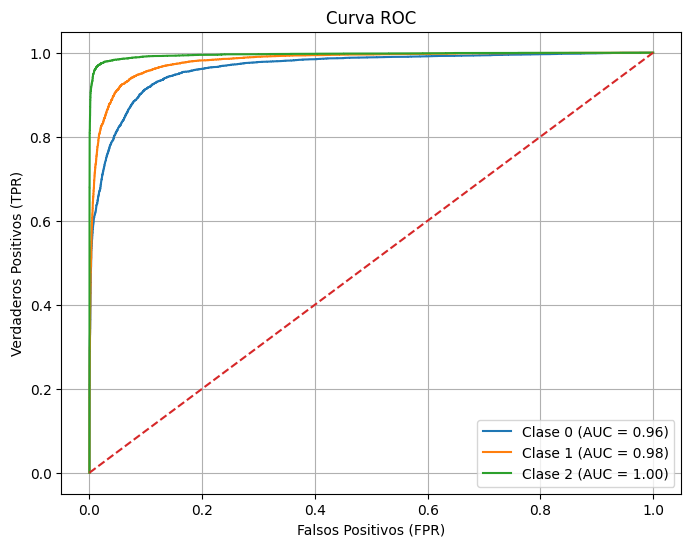

In [ ]:
# RandomForest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

# Configuración de valores para buscar el optimo
param_grid = {
    'n_estimators': [10, 20, 50],          # Número de árboles
    'max_depth': [10, 20, 50],           # Profundidad máxima
    'min_samples_split': [1, 5],
    'min_samples_leaf': [1, 2, 5],
    'class_weight': ['balanced']     # Balancear clases
}

random_forest_model = RandomForestClassifier(random_state=42, n_jobs=-1)

# Búsqueda de hiperparámetros
grid_search = GridSearchCV(
    estimator=random_forest_model,
    param_grid=param_grid,
    cv=3,
    scoring='f1_weighted',
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

y_pred = grid_search.best_estimator_.predict(X_test)
y_roc = grid_search.best_estimator_.predict_proba(X_test)

print("Mejor opción:", grid_search.best_params_)
print("\n")
print("Reporte de clasificación:")
print(classification_report(y_test, y_pred))
print("\n")

confusion_matrix = confusion_matrix(y_test, y_pred)
print("Matriz de Confusión:")
print(confusion_matrix)
print("\n")

# Curva ROC-AUC
roc_auc = roc_auc_score(y_test, y_roc, multi_class='ovr')
print("Curva AUC-ROC:")
print(f"AUC-ROC Score: {roc_auc:.2f}")

# Graficar la curva ROC para cada clase
plt.figure(figsize=(8, 6))
for i in np.unique(y_test):
    fpr, tpr, _ = roc_curve((y_test == i).astype(int), y_roc[:, i])
    plt.plot(fpr, tpr, label=f'Clase {i} (AUC = {roc_auc_score((y_test == i).astype(int), y_roc[:, i]):.2f})')

plt.plot([0, 1], [0, 1], '--')
plt.xlabel('Falsos Positivos (FPR)')
plt.ylabel('Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.grid()
plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Mejores hiperparámetros: {'C': 0.0001, 'class_weight': 'balanced', 'max_iter': 20000, 'penalty': 'l2', 'solver': 'sag'}

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.26      0.17      0.20      8032
           1       0.26      0.38      0.30      5494
           2       0.35      0.37      0.36      5820

    accuracy                           0.29     19346
   macro avg       0.29      0.30      0.29     19346
weighted avg       0.29      0.29      0.28     19346

Matriz de Confusión:
[[1347 4085 2600]
 [2074 2062 1358]
 [1758 1905 2157]]


Curva AUC-ROC:
AUC-ROC Score: 0.49


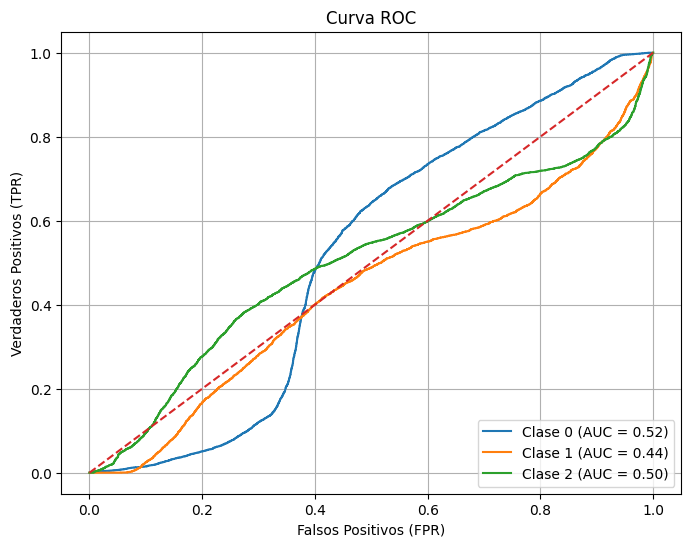

In [ ]:
#Regresion Logistica
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

# Configuración de opciones de hiperparametros
param_grid = {
    'C': [0.0001, 0.001, 0.01, 0.1],  # Regularización inversa
    'penalty': ['l2'],  # Penalización
    'solver': ['lbfgs', 'saga', 'sag'],  # Solver eficiente
    'max_iter': [20000],  # Máximo de iteraciones
    'class_weight': ['balanced']
}

log_reg_model = LogisticRegression(random_state=42, multi_class='ovr', n_jobs=-1)

# StratifiedKFold para la validación cruzada
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Búsqueda de hiperparámetros
grid_search = GridSearchCV(
    estimator=log_reg_model,
    param_grid=param_grid,
    cv=stratified_kfold,  # Utilizar StratifiedKFold
    scoring='f1_weighted',
    n_jobs=-1
)


grid_search.fit(X_train, y_train)

y_pred = grid_search.best_estimator_.predict(X_test)
y_roc = grid_search.best_estimator_.predict_proba(X_test)

# Reporte de clasificación
print("Mejores hiperparámetros:", grid_search.best_params_)
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred))

confusion_matrix = confusion_matrix(y_test, y_pred)
print("Matriz de Confusión:")
print(confusion_matrix)
print("\n")

# Curva ROC-AUC
roc_auc = roc_auc_score(y_test, y_roc, multi_class='ovr')
print("Curva AUC-ROC:")
print(f"AUC-ROC Score: {roc_auc:.2f}")

# Graficar la curva ROC para cada clase
plt.figure(figsize=(8, 6))
for i in np.unique(y_test):
    fpr, tpr, _ = roc_curve((y_test == i).astype(int), y_roc[:, i])
    plt.plot(fpr, tpr, label=f'Clase {i} (AUC = {roc_auc_score((y_test == i).astype(int), y_roc[:, i]):.2f})')

plt.plot([0, 1], [0, 1], '--')
plt.xlabel('Falsos Positivos (FPR)')
plt.ylabel('Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.grid()
plt.show()

Resultados:
              precision    recall  f1-score   support

           0       0.24      0.11      0.15      8032
           1       0.40      0.51      0.45      5494
           2       0.41      0.60      0.48      5820

    accuracy                           0.37     19346
   macro avg       0.35      0.41      0.36     19346
weighted avg       0.33      0.37      0.34     19346



Matriz de Confusión:
[[ 912 3641 3479]
 [1096 2786 1612]
 [1844  493 3483]]
AUC-ROC Score: 0.55


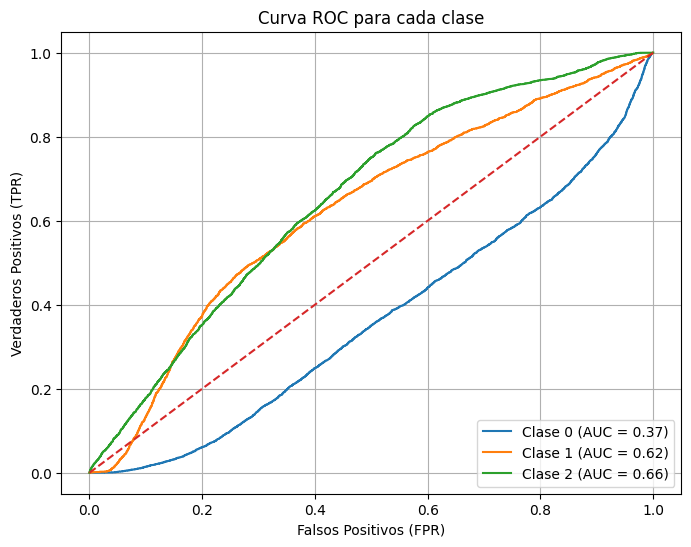

In [ ]:
#NaiveBayes
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

naive_Bayes_Model = GaussianNB()
naive_Bayes_Model.fit(X_train, y_train)

y_pred = naive_Bayes_Model.predict(X_test)
y_roc = naive_Bayes_Model.predict_proba(X_test)

print("Resultados:")
print(classification_report(y_test, y_pred))
print("\n")

confusion_matrix = confusion_matrix(y_test, y_pred)
print("Matriz de Confusión:")
print(confusion_matrix)
print("\n")

roc_auc_curve = roc_auc_score(y_test, y_roc, multi_class='ovr')  # AUC para clases múltiples
print(f"AUC-ROC Score: {roc_auc_curve:.2f}")

plt.figure(figsize=(8, 6))
for i in np.unique(y_test):
    fpr, tpr, _ = roc_curve((y_test == i).astype(int), y_roc[:, i])
    plt.plot(fpr, tpr, label=f'Clase {i} (AUC = {roc_auc_score((y_test == i).astype(int), y_roc[:, i]):.2f})')

plt.plot([0, 1], [0, 1], '--')
plt.xlabel('Falsos Positivos (FPR)')
plt.ylabel('Verdaderos Positivos (TPR)')
plt.title('Curva ROC para cada clase')
plt.legend(loc='lower right')
plt.grid()
plt.show()




Mejor opción: {'var_smoothing': 1e-30}

Resultados:
              precision    recall  f1-score   support

           0       0.24      0.11      0.15      8032
           1       0.40      0.51      0.45      5494
           2       0.41      0.60      0.48      5820

    accuracy                           0.37     19346
   macro avg       0.35      0.41      0.36     19346
weighted avg       0.33      0.37      0.34     19346



Matriz de Confusión:
[[ 912 3641 3479]
 [1096 2786 1612]
 [1844  493 3483]]


AUC-ROC Score: 0.55


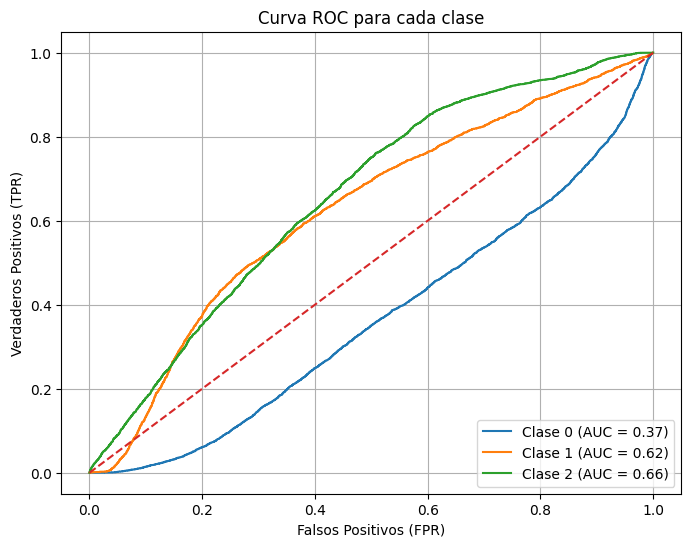

In [ ]:
#NaiveBayes con validacion cruzada
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

# Ajuste de la regularización de la varianza
param_grid = {'var_smoothing': [1e-30,1e-25,1e-20,1e-15]}

# Naive Bayes con GridSearchCV
naive_Bayes_Model = GaussianNB()
grid_search = GridSearchCV(estimator=naive_Bayes_Model,
                           param_grid=param_grid,
                           cv=3,  # Número de folds en validación cruzada
                           scoring='f1_weighted',
                           n_jobs=-1)

grid_search.fit(X_train, y_train)

best_naive_Bayes_Model = grid_search.best_estimator_
y_pred = best_naive_Bayes_Model.predict(X_test)
y_roc = best_naive_Bayes_Model.predict_proba(X_test)

print("Mejor opción:", grid_search.best_params_)
print("\nResultados:")
print(classification_report(y_test, y_pred))
print("\n")

conf_matrix = confusion_matrix(y_test, y_pred)
print("Matriz de Confusión:")
print(conf_matrix)
print("\n")

# Curva ROC-AUC
roc_auc_curve = roc_auc_score(y_test, y_roc, multi_class='ovr')  # AUC para clases múltiples
print(f"AUC-ROC Score: {roc_auc_curve:.2f}")

# Gráfica de curva ROC para cada clase
plt.figure(figsize=(8, 6))
for i in np.unique(y_test):
    fpr, tpr, _ = roc_curve((y_test == i).astype(int), y_roc[:, i])
    plt.plot(fpr, tpr, label=f'Clase {i} (AUC = {roc_auc_score((y_test == i).astype(int), y_roc[:, i]):.2f})')

plt.plot([0, 1], [0, 1], '--')
plt.xlabel('Falsos Positivos (FPR)')
plt.ylabel('Verdaderos Positivos (TPR)')
plt.title('Curva ROC para cada clase')
plt.legend(loc='lower right')
plt.grid()
plt.show()

Mejor opción: {'alpha': 1e-07, 'fit_prior': False}

Resultados:
              precision    recall  f1-score   support

           0       0.29      0.21      0.25      8032
           1       0.18      0.18      0.18      5494
           2       0.25      0.35      0.30      5820

    accuracy                           0.25     19346
   macro avg       0.24      0.25      0.24     19346
weighted avg       0.25      0.25      0.24     19346



Matriz de Confusión:
[[1714 2567 3751]
 [2207 1007 2280]
 [1892 1872 2056]]


AUC-ROC Score: 0.50


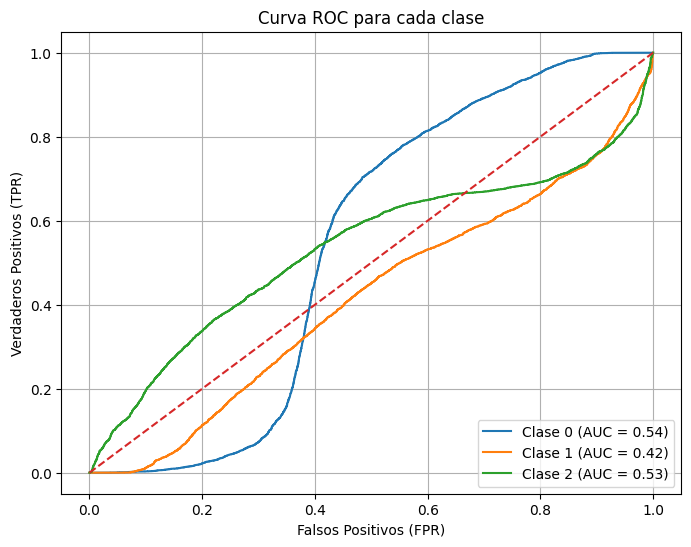

In [ ]:
#Naive Bayes con validación cruzada
from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

# Escalado de los datos
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Ajuste del parámetro alpha
param_grid = {'alpha': [0.0000001, 0.000001, 0.00001, 0.1, 0.5, 1.0, 1.5, 2.0, 3.0, 7.0],
              'fit_prior': [True, False],
              }

# Naive Bayes con GridSearchCV
naive_Bayes_Model = MultinomialNB()
grid_search = GridSearchCV(estimator=naive_Bayes_Model,
                           param_grid=param_grid,
                           cv=3,  # Número de folds en validación cruzada
                           scoring='f1_weighted',
                           n_jobs=-1)

# Entrenamiento del modelo
grid_search.fit(X_train_scaled, y_train)

# Mejor modelo encontrado
best_naive_Bayes_Model = grid_search.best_estimator_
y_pred = best_naive_Bayes_Model.predict(X_test_scaled)
y_roc = best_naive_Bayes_Model.predict_proba(X_test_scaled)

# Resultados
print("Mejor opción:", grid_search.best_params_)
print("\nResultados:")
print(classification_report(y_test, y_pred))
print("\n")

# Matriz de Confusión
conf_matrix = confusion_matrix(y_test, y_pred)
print("Matriz de Confusión:")
print(conf_matrix)
print("\n")

# Curva ROC-AUC
roc_auc_curve = roc_auc_score(y_test, y_roc, multi_class='ovr')  # AUC para clases múltiples
print(f"AUC-ROC Score: {roc_auc_curve:.2f}")

# Gráfica de curva ROC para cada clase
plt.figure(figsize=(8, 6))
for i in np.unique(y_test):
    fpr, tpr, _ = roc_curve((y_test == i).astype(int), y_roc[:, i])
    plt.plot(fpr, tpr, label=f'Clase {i} (AUC = {roc_auc_score((y_test == i).astype(int), y_roc[:, i]):.2f})')

plt.plot([0, 1], [0, 1], '--')
plt.xlabel('Falsos Positivos (FPR)')
plt.ylabel('Verdaderos Positivos (TPR)')
plt.title('Curva ROC para cada clase')
plt.legend(loc='lower right')
plt.grid()
plt.show()

Mejor opción: {'alpha': 7.0, 'binarize': 0.0, 'fit_prior': True}

Resultados:
              precision    recall  f1-score   support

           0       0.51      0.41      0.45      8032
           1       0.35      0.47      0.40      5494
           2       0.34      0.32      0.33      5820

    accuracy                           0.40     19346
   macro avg       0.40      0.40      0.39     19346
weighted avg       0.41      0.40      0.40     19346



Matriz de Confusión:
[[3281 2261 2490]
 [1744 2578 1172]
 [1382 2575 1863]]


AUC-ROC Score: 0.54


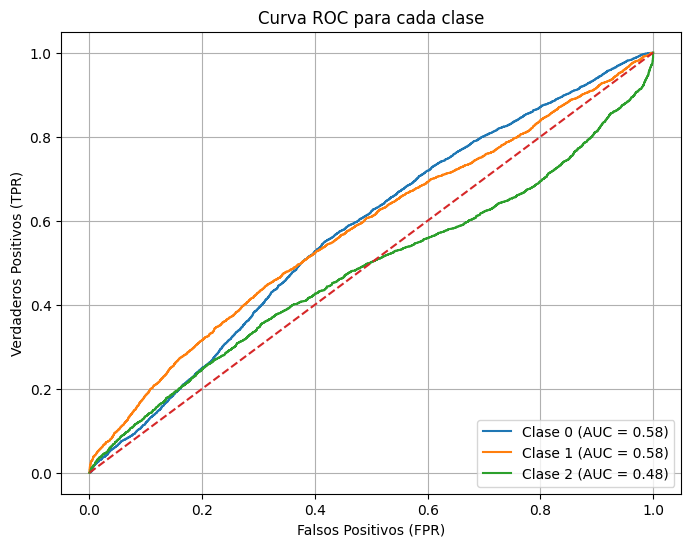

In [ ]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

# Ajuste del parámetro alpha
param_grid = {'alpha': [0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 1.5, 2.0, 3.0, 7.0],
              'binarize': [None, 0.0, 0.5, 1.0],
              'fit_prior': [True, False],
              }

# Naive Bayes con GridSearchCV
naive_Bayes_Model = BernoulliNB()
grid_search = GridSearchCV(estimator=naive_Bayes_Model,
                           param_grid=param_grid,
                           cv=3,  # Número de folds en validación cruzada
                           scoring='f1_weighted',
                           n_jobs=-1)

# Entrenamiento del modelo
grid_search.fit(X_train, y_train)

# Mejor modelo encontrado
best_naive_Bayes_Model = grid_search.best_estimator_
y_pred = best_naive_Bayes_Model.predict(X_test)
y_roc = best_naive_Bayes_Model.predict_proba(X_test)

# Resultados
print("Mejor opción:", grid_search.best_params_)
print("\nResultados:")
print(classification_report(y_test, y_pred))
print("\n")

# Matriz de Confusión
conf_matrix = confusion_matrix(y_test, y_pred)
print("Matriz de Confusión:")
print(conf_matrix)
print("\n")

# Curva ROC-AUC
roc_auc_curve = roc_auc_score(y_test, y_roc, multi_class='ovr')  # AUC para clases múltiples
print(f"AUC-ROC Score: {roc_auc_curve:.2f}")

# Gráfica de curva ROC para cada clase
plt.figure(figsize=(8, 6))
for i in np.unique(y_test):
    fpr, tpr, _ = roc_curve((y_test == i).astype(int), y_roc[:, i])
    plt.plot(fpr, tpr, label=f'Clase {i} (AUC = {roc_auc_score((y_test == i).astype(int), y_roc[:, i]):.2f})')

plt.plot([0, 1], [0, 1], '--')
plt.xlabel('Falsos Positivos (FPR)')
plt.ylabel('Verdaderos Positivos (TPR)')
plt.title('Curva ROC para cada clase')
plt.legend(loc='lower right')
plt.grid()
plt.show()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/150
1104/1104 - 5s - 5ms/step - accuracy: 0.3708 - loss: 1.0975 - val_accuracy: 0.3153 - val_loss: 1.1026
Epoch 2/150
1104/1104 - 3s - 3ms/step - accuracy: 0.4332 - loss: 1.0670 - val_accuracy: 0.3253 - val_loss: 1.1114
Epoch 3/150
1104/1104 - 6s - 6ms/step - accuracy: 0.4756 - loss: 1.0318 - val_accuracy: 0.3151 - val_loss: 1.1349
Epoch 4/150
1104/1104 - 3s - 2ms/step - accuracy: 0.5050 - loss: 0.9934 - val_accuracy: 0.3188 - val_loss: 1.1301
Epoch 5/150
1104/1104 - 4s - 4ms/step - accuracy: 0.5357 - loss: 0.9562 - val_accuracy: 0.3411 - val_loss: 1.1339
Epoch 6/150
1104/1104 - 2s - 2ms/step - accuracy: 0.5581 - loss: 0.9178 - val_accuracy: 0.3336 - val_loss: 1.1482
Epoch 7/150
1104/1104 - 3s - 3ms/step - accuracy: 0.5837 - loss: 0.8825 - val_accuracy: 0.3721 - val_loss: 1.1174
Epoch 8/150
1104/1104 - 3s - 3ms/step - accuracy: 0.6094 - loss: 0.8461 - val_accuracy: 0.4206 - val_loss: 1.0904
Epoch 9/150
1104/1104 - 4s - 4ms/step - accuracy: 0.6302 - loss: 0.8147 - val_accuracy: 

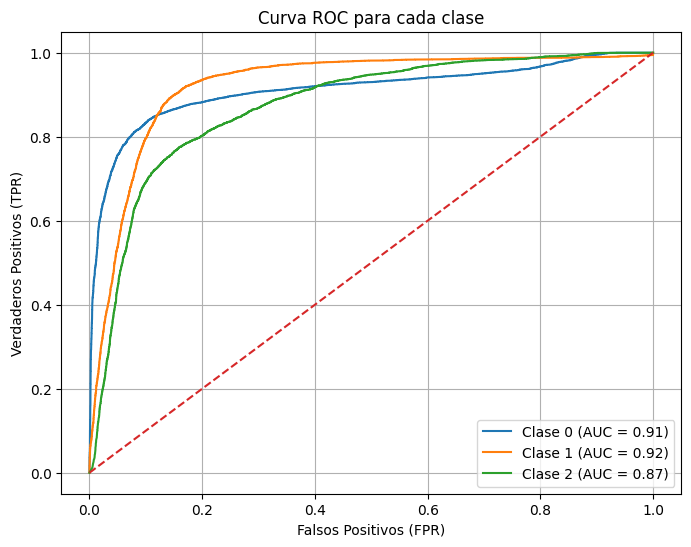

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

# Escalado de los datos
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Definición del modelo
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.3),  # Dropout para prevenir sobreajuste
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(len(np.unique(y_train)), activation='softmax')  # Capa de salida para clasificación multiclase
])

# Compilación del modelo
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',  # Para etiquetas enteras en problemas multiclase
              metrics=['accuracy'])

# Entrenamiento del modelo
history = model.fit(X_train_scaled, y_train,
                    validation_data=(X_test_scaled, y_test),
                    epochs=150,
                    batch_size=64,
                    verbose=2)

# Evaluación en el conjunto de prueba
loss, accuracy = model.evaluate(X_test_scaled, y_test, verbose=0)
print(f"Accuracy en el conjunto de prueba: {accuracy:.2f}")

# Predicciones
y_pred = np.argmax(model.predict(X_test_scaled), axis=1)
y_roc = model.predict(X_test_scaled)

# Reporte de clasificación
print("\nResultados:")
print(classification_report(y_test, y_pred))

# Matriz de Confusión
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nMatriz de Confusión:")
print(conf_matrix)

# Curva ROC-AUC
roc_auc_curve = roc_auc_score(y_test, y_roc, multi_class='ovr')  # AUC para clases múltiples
print(f"AUC-ROC Score: {roc_auc_curve:.2f}")

# Gráfica de curva ROC para cada clase
plt.figure(figsize=(8, 6))
for i in np.unique(y_test):
    fpr, tpr, _ = roc_curve((y_test == i).astype(int), y_roc[:, i])
    plt.plot(fpr, tpr, label=f'Clase {i} (AUC = {roc_auc_score((y_test == i).astype(int), y_roc[:, i]):.2f})')

plt.plot([0, 1], [0, 1], '--')
plt.xlabel('Falsos Positivos (FPR)')
plt.ylabel('Verdaderos Positivos (TPR)')
plt.title('Curva ROC para cada clase')
plt.legend(loc='lower right')
plt.grid()
plt.show()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/150
1104/1104 - 10s - 9ms/step - accuracy: 0.3773 - loss: 1.0910 - val_accuracy: 0.2884 - val_loss: 1.1002
Epoch 2/150
1104/1104 - 9s - 8ms/step - accuracy: 0.4798 - loss: 1.0217 - val_accuracy: 0.3101 - val_loss: 1.1040
Epoch 3/150
1104/1104 - 4s - 4ms/step - accuracy: 0.5517 - loss: 0.9271 - val_accuracy: 0.3402 - val_loss: 1.1138
Epoch 4/150
1104/1104 - 4s - 4ms/step - accuracy: 0.6051 - loss: 0.8475 - val_accuracy: 0.4478 - val_loss: 1.0363
Epoch 5/150
1104/1104 - 6s - 6ms/step - accuracy: 0.6548 - loss: 0.7797 - val_accuracy: 0.5003 - val_loss: 1.0054
Epoch 6/150
1104/1104 - 4s - 4ms/step - accuracy: 0.6831 - loss: 0.7292 - val_accuracy: 0.5439 - val_loss: 0.9377
Epoch 7/150
1104/1104 - 10s - 9ms/step - accuracy: 0.7077 - loss: 0.6869 - val_accuracy: 0.5631 - val_loss: 0.9164
Epoch 8/150
1104/1104 - 8s - 7ms/step - accuracy: 0.7259 - loss: 0.6503 - val_accuracy: 0.5645 - val_loss: 0.9226
Epoch 9/150
1104/1104 - 11s - 10ms/step - accuracy: 0.7418 - loss: 0.6176 - val_accura

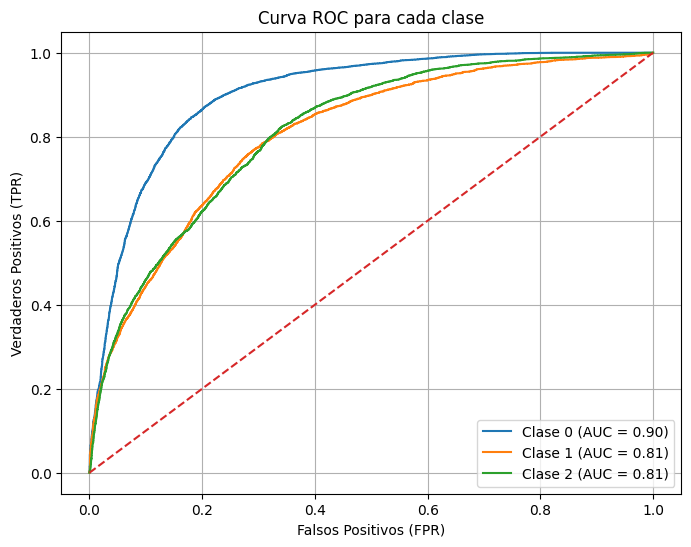

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

# Escalado de los datos
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Definición del modelo
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.4),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(len(np.unique(y_train)), activation='softmax')
])

# Compilación del modelo
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',  # Para etiquetas enteras en problemas multiclase
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss',
                                patience=10,
                                restore_best_weights=True)  # Restaurar los mejores pesos

# Entrenamiento del modelo
history = model.fit(X_train_scaled, y_train,
                    validation_data=(X_test_scaled, y_test),
                    epochs=150,  # Ajusta según el tiempo y el rendimiento
                    batch_size=64,  # Tamaño del batch para aprovechar mejor los recursos
                    verbose=2,
                    callbacks=[early_stopping])

# Evaluación en el conjunto de prueba
loss, accuracy = model.evaluate(X_test_scaled, y_test, verbose=0)
print(f"Accuracy en el conjunto de prueba: {accuracy:.2f}")

# Predicciones
y_pred = np.argmax(model.predict(X_test_scaled), axis=1)
y_roc = model.predict(X_test_scaled)

# Reporte de clasificación
print("\nResultados:")
print(classification_report(y_test, y_pred))

# Matriz de Confusión
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nMatriz de Confusión:")
print(conf_matrix)

# Curva ROC-AUC
roc_auc_curve = roc_auc_score(y_test, y_roc, multi_class='ovr')  # AUC para clases múltiples
print(f"AUC-ROC Score: {roc_auc_curve:.2f}")

# Gráfica de curva ROC para cada clase
plt.figure(figsize=(8, 6))
for i in np.unique(y_test):
    fpr, tpr, _ = roc_curve((y_test == i).astype(int), y_roc[:, i])
    plt.plot(fpr, tpr, label=f'Clase {i} (AUC = {roc_auc_score((y_test == i).astype(int), y_roc[:, i]):.2f})')

plt.plot([0, 1], [0, 1], '--')
plt.xlabel('Falsos Positivos (FPR)')
plt.ylabel('Verdaderos Positivos (TPR)')
plt.title('Curva ROC para cada clase')
plt.legend(loc='lower right')
plt.grid()
plt.show()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/150
1104/1104 - 15s - 13ms/step - accuracy: 0.3572 - loss: 1.2149 - val_accuracy: 0.2546 - val_loss: 1.1940 - learning_rate: 1.0000e-04
Epoch 2/150
1104/1104 - 11s - 10ms/step - accuracy: 0.4468 - loss: 1.1220 - val_accuracy: 0.4198 - val_loss: 1.1419 - learning_rate: 1.0000e-04
Epoch 3/150
1104/1104 - 3s - 3ms/step - accuracy: 0.5664 - loss: 0.9792 - val_accuracy: 0.4565 - val_loss: 1.0989 - learning_rate: 1.0000e-04
Epoch 4/150
1104/1104 - 3s - 2ms/step - accuracy: 0.6505 - loss: 0.8566 - val_accuracy: 0.5658 - val_loss: 0.9869 - learning_rate: 1.0000e-04
Epoch 5/150
1104/1104 - 5s - 5ms/step - accuracy: 0.6911 - loss: 0.7775 - val_accuracy: 0.6086 - val_loss: 0.9291 - learning_rate: 1.0000e-04
Epoch 6/150
1104/1104 - 3s - 2ms/step - accuracy: 0.7170 - loss: 0.7292 - val_accuracy: 0.5630 - val_loss: 1.0029 - learning_rate: 1.0000e-04
Epoch 7/150
1104/1104 - 3s - 3ms/step - accuracy: 0.7397 - loss: 0.6842 - val_accuracy: 0.6530 - val_loss: 0.8389 - learning_rate: 1.0000e-04
Ep

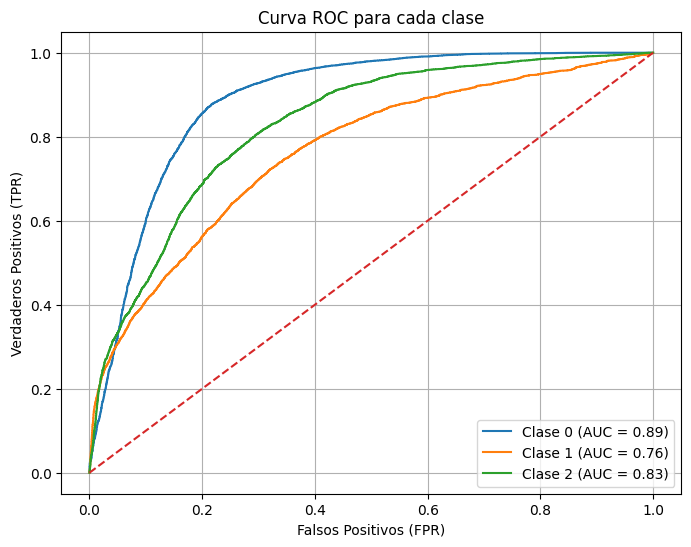

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Escalado de los datos
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Definición del modelo
model = Sequential([
    Dense(512, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.4),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(len(np.unique(y_train)), activation='softmax')
])

# Compilación del modelo
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',  # Para etiquetas enteras en problemas multiclase
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss',  # Supervisar la pérdida de validación
                                patience=12,         # Esperar 12 épocas sin mejora
                                restore_best_weights=True)  # Restaurar los mejores pesos

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Entrenamiento del modelo
history = model.fit(X_train_scaled, y_train,
                    validation_data=(X_test_scaled, y_test),
                    epochs=150,
                    batch_size=64,
                    verbose=2,
                    callbacks=[early_stopping, reduce_lr])

# Evaluación en el conjunto de prueba
loss, accuracy = model.evaluate(X_test_scaled, y_test, verbose=0)
print(f"Accuracy en el conjunto de prueba: {accuracy:.2f}")

# Predicciones
y_pred = np.argmax(model.predict(X_test_scaled), axis=1)
y_roc = model.predict(X_test_scaled)

# Reporte de clasificación
print("\nResultados:")
print(classification_report(y_test, y_pred))

# Matriz de Confusión
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nMatriz de Confusión:")
print(conf_matrix)

# Curva ROC-AUC
roc_auc_curve = roc_auc_score(y_test, y_roc, multi_class='ovr')  # AUC para clases múltiples
print(f"AUC-ROC Score: {roc_auc_curve:.2f}")

# Gráfica de curva ROC para cada clase
plt.figure(figsize=(8, 6))
for i in np.unique(y_test):
    fpr, tpr, _ = roc_curve((y_test == i).astype(int), y_roc[:, i])
    plt.plot(fpr, tpr, label=f'Clase {i} (AUC = {roc_auc_score((y_test == i).astype(int), y_roc[:, i]):.2f})')

plt.plot([0, 1], [0, 1], '--')
plt.xlabel('Falsos Positivos (FPR)')
plt.ylabel('Verdaderos Positivos (TPR)')
plt.title('Curva ROC para cada clase')
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [ ]:
# Necesario para que funcione en el entorno, actualizar esta librería
# !pip install xgboost==1.7.6

Hiperparámetros utilizados: {'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 700, 'subsample': 0.8, 'colsample_bytree': 0.8}

Resultados:
              precision    recall  f1-score   support

           0       0.97      0.67      0.79      8032
           1       0.63      0.98      0.77      5494
           2       1.00      0.91      0.95      5820

    accuracy                           0.83     19346
   macro avg       0.87      0.85      0.84     19346
weighted avg       0.88      0.83      0.83     19346



Matriz de Confusión:
[[5347 2683    2]
 [  82 5404    8]
 [  98  443 5279]]


AUC-ROC Score: 0.98


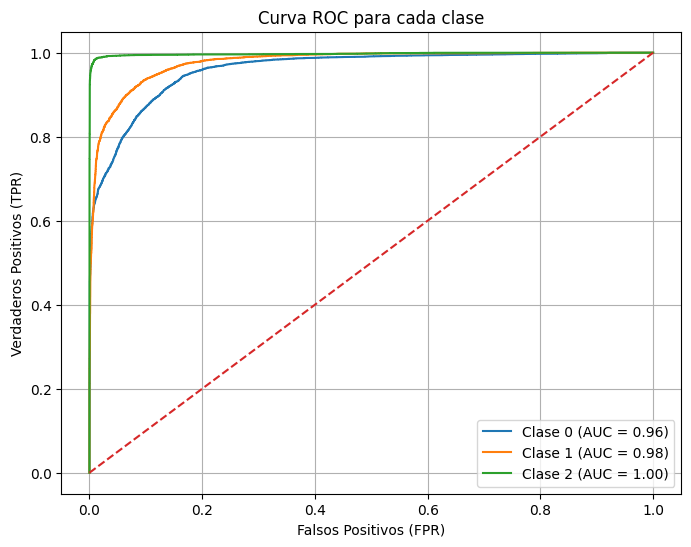

In [ ]:
# GradientBoost
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

fixed_params = {
    'learning_rate': 0.01,
    'max_depth': 10,
    'n_estimators': 700,
    'subsample': 0.8,
    'colsample_bytree': 0.8
}

xgb_model = XGBClassifier(
    learning_rate=fixed_params['learning_rate'],
    max_depth=fixed_params['max_depth'],
    n_estimators=fixed_params['n_estimators'],
    subsample=fixed_params['subsample'],
    colsample_bytree=fixed_params['colsample_bytree'],
    eval_metric='logloss',
    random_state=42
)

xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)
y_roc = xgb_model.predict_proba(X_test)

# Resultados
print("Hiperparámetros utilizados:", fixed_params)
print("\nResultados:")
print(classification_report(y_test, y_pred))
print("\n")

# Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)
print("Matriz de Confusión:")
print(conf_matrix)
print("\n")

# Curva ROC-AUC
roc_auc_curve = roc_auc_score(y_test, y_roc, multi_class='ovr')
print(f"AUC-ROC Score: {roc_auc_curve:.2f}")

# Gráfica de curva ROC para cada clase
plt.figure(figsize=(8, 6))
for i in np.unique(y_test):
    fpr, tpr, _ = roc_curve((y_test == i).astype(int), y_roc[:, i])
    plt.plot(fpr, tpr, label=f'Clase {i} (AUC = {roc_auc_score((y_test == i).astype(int), y_roc[:, i]):.2f})')

plt.plot([0, 1], [0, 1], '--')
plt.xlabel('Falsos Positivos (FPR)')
plt.ylabel('Verdaderos Positivos (TPR)')
plt.title('Curva ROC para cada clase')
plt.legend(loc='lower right')
plt.grid()
plt.show()


# HuggingFace

**Se importan las librerías necesarias, en caso de no tenerlas importadas ya**

In [ ]:
# preparación de librerias
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import spacy

**Se cargan los datos del subconjunto original de 568.000 muestras de reseñas de prosuctos para tener en torno a las 86.000, ya que no se puede usar los datos ya tokenizados, Huggingface trabaja con textos directamente y tokeniza de una manera determinada, en funcion del modelo utilizado**

In [ ]:
# Cargamos el csv_modelado
df_loaded = pd.read_csv('/content/sample_reviews.csv')
df_loaded.head(10)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1603,B001RVFDOO,A1UV8UCBOYABKQ,deek,0,0,5,1329091200,yummy,These chips are wonderful. My kids and I all ...
1,1604,B001RVFDOO,A1MFIN31SXO81A,Foof,0,0,5,1329091200,Great Item,"Great packaging, and item is just as described..."
2,1605,B001RVFDOO,A1EMVE0E166IKY,G. Pliler,0,0,5,1329004800,Excellent chips,Just to give a little background - I ordered t...
3,1606,B001RVFDOO,A2ZNXVTFNE6MQO,"Lori ""Lori""",0,0,5,1328918400,Perfect for WW followers,Got this item on a one-day-only sale on Amazon...
4,1607,B001RVFDOO,A30QMNHLS0YTKI,"L. Ferguson ""WineChick""",0,0,5,1328572800,"Variety pack, packed lunches",I discovered Pop Chips awhile back and fell in...
5,1608,B001RVFDOO,AU0PC4RM01IOD,"C. CARPENTER ""part-time reader""",0,0,4,1328572800,Loved all the flavor except salt and pepper!,I really liked these chips as did my entire fa...
6,1609,B001RVFDOO,A2JKRWF7RCCI1,Tony's diamond,0,0,3,1328572800,chips,These popchips were something I wanted to try ...
7,1610,B001RVFDOO,A3PD8JD9L4WEII,"Bron ""Bron""",0,0,4,1328313600,Good as a sampler pack of the various flavors,"I like these Pop Chips a lot, but not all the ..."
8,1611,B001RVFDOO,A2HKGQ3OBD6Q23,D. Yang,0,0,5,1328054400,These tastes pretty good,"These tastes good. If it's not fried, not bad ..."
9,1612,B001RVFDOO,AX8KKN5A1PG9E,"CintiBonnie ""bonnie8""",0,0,2,1327622400,Didn't care for the variety selections,I bought two bags of PopChips at Whole Foods (...


**Se eliminan las filas que no son necesarias para el estudio**

In [ ]:
# Seleccionamos las columnas que deseamos eliminar
columns_drop = ['Id', 'UserId', 'ProfileName', 'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Time']

# Eliminamos las columnas seleccionadas
df_loaded_dropped = df_loaded.drop(columns=columns_drop)

# Mostramos el resultado para comprobar la eliminación
df_loaded_dropped.head()

,ProductId,Score,Summary,Text
0,B001RVFDOO,5,yummy,These chips are wonderful. My kids and I all ...
1,B001RVFDOO,5,Great Item,"Great packaging, and item is just as described..."
2,B001RVFDOO,5,Excellent chips,Just to give a little background - I ordered t...
3,B001RVFDOO,5,Perfect for WW followers,Got this item on a one-day-only sale on Amazon...
4,B001RVFDOO,5,"Variety pack, packed lunches",I discovered Pop Chips awhile back and fell in...


**Se verifica tamaño**

In [ ]:
df_loaded_dropped.shape

(86565, 4)

**Se concatenan las columnas de texto**

In [ ]:
# Concatenamos las columnas Transformed_Text y Transformed_Summary. se usa fillna para sustituir
# los valores nulos por cadenas vacias
df_loaded_dropped['Review'] = df_loaded_dropped['Summary'].fillna('') + " " + df_loaded_dropped['Text'].fillna('')
df_loaded_dropped.head()

,ProductId,Score,Summary,Text,Review
0,B001RVFDOO,5,yummy,These chips are wonderful. My kids and I all ...,yummy These chips are wonderful. My kids and ...
1,B001RVFDOO,5,Great Item,"Great packaging, and item is just as described...","Great Item Great packaging, and item is just a..."
2,B001RVFDOO,5,Excellent chips,Just to give a little background - I ordered t...,Excellent chips Just to give a little backgrou...
3,B001RVFDOO,5,Perfect for WW followers,Got this item on a one-day-only sale on Amazon...,Perfect for WW followers Got this item on a on...
4,B001RVFDOO,5,"Variety pack, packed lunches",I discovered Pop Chips awhile back and fell in...,"Variety pack, packed lunches I discovered Pop ..."


**Se eliminan las originales una vez no son necesarias ya**

In [ ]:
# Eliminamos las columnas de Texto y Resumen, una vez estan ya concatenadas
df_loaded_dropped.drop(['Text', 'Summary'], axis=1, inplace=True)
df_loaded_dropped.head()

,ProductId,Score,Review
0,B001RVFDOO,5,yummy These chips are wonderful. My kids and ...
1,B001RVFDOO,5,"Great Item Great packaging, and item is just a..."
2,B001RVFDOO,5,Excellent chips Just to give a little backgrou...
3,B001RVFDOO,5,Perfect for WW followers Got this item on a on...
4,B001RVFDOO,5,"Variety pack, packed lunches I discovered Pop ..."


**Se crea la feature a partir de Score para tener reseñas positivas, neutras y negativas**

In [ ]:
# Creamos la nueva feature a partir de Score para clasificar en buenas o malas las reseñas.
df_loaded_dropped['Label'] = df_loaded_dropped['Score'].apply(lambda x: 'negative' if x in [1, 2] else ('neutral' if x == 3 else 'positive'))

# Reordenamos las columnas para que la nueva columna aparezca antes de 'Score'
columns = list(df_loaded_dropped.columns)
columns.remove('Label')
columns.insert(columns.index('Score'), 'Label')
df_loaded_dropped = df_loaded_dropped[columns]
df_loaded_dropped.head(40)

,ProductId,Label,Score,Review
0,B001RVFDOO,positive,5,yummy These chips are wonderful. My kids and ...
1,B001RVFDOO,positive,5,"Great Item Great packaging, and item is just a..."
2,B001RVFDOO,positive,5,Excellent chips Just to give a little backgrou...
3,B001RVFDOO,positive,5,Perfect for WW followers Got this item on a on...
4,B001RVFDOO,positive,5,"Variety pack, packed lunches I discovered Pop ..."
5,B001RVFDOO,positive,4,Loved all the flavor except salt and pepper! I...
6,B001RVFDOO,neutral,3,chips These popchips were something I wanted t...
7,B001RVFDOO,positive,4,Good as a sampler pack of the various flavors ...
8,B001RVFDOO,positive,5,These tastes pretty good These tastes good. If...
9,B001RVFDOO,negative,2,Didn't care for the variety selections I bough...


**Se codifica la columna de Label**

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Codificamos la columna Label con LabelEncoder (para la variable objetivo)
label_encoder = LabelEncoder()
df_loaded_dropped['Label_Encoded'] = label_encoder.fit_transform(df_loaded_dropped['Label'])

# Eliminamos la columna Score y mostramos resultados
df_loaded_dropped.drop(columns=['Label'], inplace=True)
df_loaded_dropped.head()

,ProductId,Score,Review,Label_Encoded
0,B001RVFDOO,5,yummy These chips are wonderful. My kids and ...,2
1,B001RVFDOO,5,"Great Item Great packaging, and item is just a...",2
2,B001RVFDOO,5,Excellent chips Just to give a little backgrou...,2
3,B001RVFDOO,5,Perfect for WW followers Got this item on a on...,2
4,B001RVFDOO,5,"Variety pack, packed lunches I discovered Pop ...",2


In [ ]:
# Eliminamos la columna Score y mostramos resultados
df_loaded_dropped.drop(columns=['Score'], inplace=True)
df_loaded_dropped.head()

,ProductId,Review,Label_Encoded
0,B001RVFDOO,yummy These chips are wonderful. My kids and ...,2
1,B001RVFDOO,"Great Item Great packaging, and item is just a...",2
2,B001RVFDOO,Excellent chips Just to give a little backgrou...,2
3,B001RVFDOO,Perfect for WW followers Got this item on a on...,2
4,B001RVFDOO,"Variety pack, packed lunches I discovered Pop ...",2


**Se realiza submuestreo de la clase mayoritaria**

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
import pandas as pd

# Distribución inicial de las clases
print("Distribución de clases antes del submuestreo:")
print(df_loaded_dropped['Label_Encoded'].value_counts())

# Configuramos el submuestreador para la clase 2
undersampler = RandomUnderSampler(sampling_strategy={2: 30000}, random_state=42)  # Reducir clase 2 a 40,000 muestras

# Preparamos las columnas necesarias
X_text = df_loaded_dropped['Review'].fillna('')  # Columna de texto
y_labels = df_loaded_dropped['Label_Encoded']    # Etiquetas
product_ids = df_loaded_dropped['ProductId']     # Columna ProductId

# Creamos un DataFrame combinado para el submuestreo
df_hugging_combined = pd.DataFrame({
    'Review': X_text,
    'Label_Encoded': y_labels,
    'ProductId': product_ids
})

# Submuestreo
df_hugging_under = pd.DataFrame(undersampler.fit_resample(df_loaded_dropped, df_loaded_dropped['Label_Encoded'])[0])

# Recuperamos las columnas submuestreadas
X_hugging_under_text = df_hugging_under['Review']         # Textos submuestreados
y_hugging_under_labels = df_hugging_under['Label_Encoded']  # Etiquetas submuestreadas
product_hugging_ids_under = df_hugging_under['ProductId']  # ProductId submuestreado

# Verificamos la distribución después del submuestreo
print("Distribución de clases después del submuestreo:")
print(y_hugging_under_labels.value_counts())
print("\n")


df_hugging_under.head()

Distribución de clases antes del submuestreo:
Label_Encoded
2    66782
0    11029
1     8754
Name: count, dtype: int64
Distribución de clases después del submuestreo:
Label_Encoded
2    30000
0    11029
1     8754
Name: count, dtype: int64




,ProductId,Review,Label_Encoded
9,B001RVFDOO,Didn't care for the variety selections I bough...,0
39,B001RVFDOO,Did not care for these. Only liked bbq. Wonder...,0
65,B001RVFDOO,Too salty Very tasty chips( ORIGINAL AND OTHER...,0
105,B001RVFDOO,"Beware hidden ingredients I hate to type this,...",0
107,B001RVFDOO,"Pringles, instant coffee, and Stephen Baldwin ...",0


**Se realiza sobremuestreo, multiplicando muestras del resto de clases**

In [ ]:
from sklearn.utils import resample
import pandas as pd

# Dividimos los datos en 3 clases, las mismas que en Label_Encoded
zero = df_hugging_under[df_hugging_under.Label_Encoded == 0]
one = df_hugging_under[df_hugging_under.Label_Encoded == 1]
two = df_hugging_under[df_hugging_under.Label_Encoded == 2]  # Clase mayoritaria

# Sobremuestreo de las clases minoritarias igualando al numero de muestras de la mayoritaria
zero_upsampled = resample(
    zero,
    replace=True,
    n_samples=len(two),
    random_state=42
)

one_upsampled = resample(
    one,
    replace=True,
    n_samples=len(two),
    random_state=42
)

# Combinamos todas las clases
df_hugging_balanced = pd.concat([zero_upsampled, one_upsampled, two]).sample(frac=1).reset_index(drop=True)
df_hugging_balanced.head()

,ProductId,Review,Label_Encoded
0,B0051COPH6,*****5 Stars ***** I only wish they had this s...,2
1,B000PDWBKO,Tasted Great... For About 3 Weeks I was a bit ...,0
2,B0007A0AQM,"Nice, healthy treats Not much to say that hasn...",2
3,B005ZBZLT4,Excellence in every way! This product is exact...,2
4,B002IEZJMA,OK but too expensive for my budget This stuff ...,1


In [ ]:
df_hugging_balanced.shape

(90000, 3)

**Se realiza la tokenización de Hugginface**

In [ ]:
# !pip install datasets
# !pip install transformers==4.33.0 tensorflow==2.12.0

In [ ]:
print(df_hugging_balanced.columns)

Index(['ProductId', 'Review', 'Label_Encoded'], dtype='object')


**HuggingFace - huawei-noah/TinyBERT_General_4L_312D (TinyBERT (4L, 312D))**

In [ ]:
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Se dividen los datos en función de ProductId para entrenamiento y test
product_ids_train, product_ids_test = train_test_split(
    df_hugging_balanced['ProductId'].unique(), test_size=0.2, random_state=42
)

# Filtramos las lineas en función de ProductId
train_indices = df_hugging_balanced['ProductId'].isin(product_ids_train)
test_indices = df_hugging_balanced['ProductId'].isin(product_ids_test)
df_train = df_hugging_balanced[train_indices]
df_test = df_hugging_balanced[test_indices]

model_token_name = "huawei-noah/TinyBERT_General_4L_312D"

# Se carga el tokenizador con el modelo deseado, y una longitud maxima de token para ahorrar memoria RAM
tokenizer = AutoTokenizer.from_pretrained(model_token_name)
tokenizer.model_max_length = 64

# Función de tokenización y escritura en TFRecord
def encode(review, label):
    tokens = tokenizer(
        review,  # String
        padding="max_length",
        truncation=True,
        return_tensors="np"
    )
    return tokens["input_ids"][0], tokens["attention_mask"][0], label

# Función para escribir los datos en TFRecords y ahorrar RAM
def write_tfrecord(data, filename):
    with tf.io.TFRecordWriter(filename) as writer:
        for review, label in zip(data["Review"], data["Label_Encoded"]):
            input_ids, attention_mask, label = encode(review, label)
            features = {
                "input_ids": tf.train.Feature(int64_list=tf.train.Int64List(value=input_ids)),
                "attention_mask": tf.train.Feature(int64_list=tf.train.Int64List(value=attention_mask)),
                "label": tf.train.Feature(int64_list=tf.train.Int64List(value=[label])),
            }
            dataRecord = tf.train.Example(features=tf.train.Features(feature=features))
            writer.write(dataRecord.SerializeToString())

write_tfrecord(df_train, "train.tfrecord")
write_tfrecord(df_test, "test.tfrecord")

# Función para poder leer los TFRecord creados
def parse_tfrecord_fn(dataRecord):
    feature_description = {
        "input_ids": tf.io.FixedLenFeature([tokenizer.model_max_length], tf.int64),
        "attention_mask": tf.io.FixedLenFeature([tokenizer.model_max_length], tf.int64),
        "label": tf.io.FixedLenFeature([], tf.int64),
    }
    dataRecord = tf.io.parse_single_example(dataRecord, feature_description)
    return {
        "input_ids": dataRecord["input_ids"],
        "attention_mask": dataRecord["attention_mask"]
    }, dataRecord["label"]

# Leemos los TFRecords
train_dataset = tf.data.TFRecordDataset("train.tfrecord").map(parse_tfrecord_fn).batch(16).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.TFRecordDataset("test.tfrecord").map(parse_tfrecord_fn).batch(16).prefetch(tf.data.AUTOTUNE)

# Cargamos el modelo preentrenado, debe coincidir con el tokenizador
model_name = model_token_name
num_labels = len(np.unique(df_train["Label_Encoded"]))

# Definición, compilación y entrenamiento del modelo
huggingFace_model = TFAutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels,from_pt=True)
huggingFace_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)
history = huggingFace_model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=10,
    verbose=2
)

# Evaluación del modelo
loss, accuracy = huggingFace_model.evaluate(test_dataset, verbose=0)
print(f"Accuracy en el conjunto de prueba: {accuracy:.2f}")

# Predicciones y métricas adicionales
y_pred_logits = []
y_true_labels = []

for batch in test_dataset:
    inputs, labels = batch
    logits = huggingFace_model.predict(inputs)["logits"]
    y_pred_logits.append(logits)
    y_true_labels.append(labels)

# Concatenar las predicciones y las etiquetas reales
y_pred_logits = np.concatenate(y_pred_logits, axis=0)
y_true_labels = np.concatenate(y_true_labels, axis=0)
y_pred = np.argmax(y_pred_logits, axis=1)

# Reporte de clasificación
print("\nResultados:")
print(classification_report(y_true_labels, y_pred))
print("\n")

# Matriz de confusión
conf_matrix = confusion_matrix(y_true_labels, y_pred)
print("\nMatriz de Confusión:")
print(conf_matrix)
print("\n")

# Curva ROC-AUC
y_probs = tf.nn.softmax(y_pred_logits).numpy()
roc_auc_curve = roc_auc_score(y_true_labels, y_probs, multi_class='ovr')
print(f"AUC-ROC Score: {roc_auc_curve:.2f}")

# Gráfica de curva ROC para cada clase
plt.figure(figsize=(8, 6))
for i in range(num_labels):
    fpr, tpr, _ = roc_curve((y_true_labels == i).astype(int), y_probs[:, i])
    plt.plot(fpr, tpr, label=f'Clase {i} (AUC = {roc_auc_score((y_true_labels == i).astype(int), y_probs[:, i]):.2f})')

plt.plot([0, 1], [0, 1], '--')
plt.xlabel('Falsos Positivos (FPR)')
plt.ylabel('Verdaderos Positivos (TPR)')
plt.title('Curva ROC para cada clase')
plt.legend(loc='lower right')
plt.grid()
plt.show()



'from sklearn.model_selection import train_test_split\nfrom transformers import AutoTokenizer, TFAutoModelForSequenceClassification\nfrom sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve\nimport tensorflow as tf\nimport numpy as np\nimport matplotlib.pyplot as plt\n\n# Se dividen los datos en función de ProductId para entrenamiento y test\nproduct_ids_train, product_ids_test = train_test_split(\n    df_hugging_balanced[\'ProductId\'].unique(), test_size=0.2, random_state=42\n)\n\n# Filtramos las lineas en función de ProductId\ntrain_indices = df_hugging_balanced[\'ProductId\'].isin(product_ids_train)\ntest_indices = df_hugging_balanced[\'ProductId\'].isin(product_ids_test)\ndf_train = df_hugging_balanced[train_indices]\ndf_test = df_hugging_balanced[test_indices]\n\nmodel_token_name = "huawei-noah/TinyBERT_General_4L_312D"\n\n# Se carga el tokenizador con el modelo deseado, y una longitud maxima de token para ahorrar memoria RAM\ntokenizer = Auto

**HuggingFace - DistilBERT**

In [ ]:
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time

start_time = time.time()
# Se dividen los datos en función de ProductId para entrenamiento y test
product_ids_train, product_ids_test = train_test_split(
    df_hugging_balanced['ProductId'].unique(), test_size=0.2, random_state=42
)

# Filtramos las lineas en función de ProductId
train_indices = df_hugging_balanced['ProductId'].isin(product_ids_train)
test_indices = df_hugging_balanced['ProductId'].isin(product_ids_test)
df_train = df_hugging_balanced[train_indices]
df_test = df_hugging_balanced[test_indices]

model_token_name = "distilbert-base-uncased"

# Se carga el tokenizador con el modelo deseado, y una longitud maxima de token para ahorrar memoria RAM
tokenizer = AutoTokenizer.from_pretrained(model_token_name)
tokenizer.model_max_length = 32

# Función de tokenización y escritura en TFRecord
def encode(review, label):
    tokens = tokenizer(
        review,  # String
        padding="max_length",
        truncation=True,
        return_tensors="np"
    )
    return tokens["input_ids"][0], tokens["attention_mask"][0], label

# Función para escribir los datos en TFRecords y ahorrar RAM
def write_tfrecord(data, filename):
    with tf.io.TFRecordWriter(filename) as writer:
        for review, label in zip(data["Review"], data["Label_Encoded"]):
            input_ids, attention_mask, label = encode(review, label)
            features = {
                "input_ids": tf.train.Feature(int64_list=tf.train.Int64List(value=input_ids)),
                "attention_mask": tf.train.Feature(int64_list=tf.train.Int64List(value=attention_mask)),
                "label": tf.train.Feature(int64_list=tf.train.Int64List(value=[label])),
            }
            dataRecord = tf.train.Example(features=tf.train.Features(feature=features))
            writer.write(dataRecord.SerializeToString())

write_tfrecord(df_train, "train.tfrecord")
write_tfrecord(df_test, "test.tfrecord")

# Función para poder leer los TFRecord creados
def parse_tfrecord_fn(dataRecord):
    feature_description = {
        "input_ids": tf.io.FixedLenFeature([tokenizer.model_max_length], tf.int64),
        "attention_mask": tf.io.FixedLenFeature([tokenizer.model_max_length], tf.int64),
        "label": tf.io.FixedLenFeature([], tf.int64),
    }
    dataRecord = tf.io.parse_single_example(dataRecord, feature_description)
    return {
        "input_ids": dataRecord["input_ids"],
        "attention_mask": dataRecord["attention_mask"]
    }, dataRecord["label"]

# Leemos los TFRecords
train_dataset = tf.data.TFRecordDataset("train.tfrecord").map(parse_tfrecord_fn).batch(8).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.TFRecordDataset("test.tfrecord").map(parse_tfrecord_fn).batch(8).prefetch(tf.data.AUTOTUNE)

# Cargamos el modelo preentrenado, debe coincidir con el tokenizador
model_name = model_token_name
num_labels = len(np.unique(df_train["Label_Encoded"]))

# Definición, compilación y entrenamiento del modelo
huggingFace_model = TFAutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
huggingFace_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)
history = huggingFace_model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=10,
    verbose=2
)

# Evaluación del modelo
loss, accuracy = huggingFace_model.evaluate(test_dataset, verbose=0)
print(f"Accuracy en el conjunto de prueba: {accuracy:.2f}")

# Predicciones y métricas adicionales
y_pred_logits = []
y_true_labels = []

for batch in test_dataset:
    inputs, labels = batch
    logits = huggingFace_model.predict(inputs)["logits"]
    y_pred_logits.append(logits)
    y_true_labels.append(labels)

# Concatenar las predicciones y las etiquetas reales
y_pred_logits = np.concatenate(y_pred_logits, axis=0)
y_true_labels = np.concatenate(y_true_labels, axis=0)
y_pred = np.argmax(y_pred_logits, axis=1)

# Reporte de clasificación
print("\nResultados:")
print(classification_report(y_true_labels, y_pred))
print("\n")

# Matriz de confusión
conf_matrix = confusion_matrix(y_true_labels, y_pred)
print("\nMatriz de Confusión:")
print(conf_matrix)
print("\n")

# Curva ROC-AUC
y_probs = tf.nn.softmax(y_pred_logits).numpy()
roc_auc_curve = roc_auc_score(y_true_labels, y_probs, multi_class='ovr')
print(f"AUC-ROC Score: {roc_auc_curve:.2f}")

# Gráfica de curva ROC para cada clase
plt.figure(figsize=(8, 6))
for i in range(num_labels):
    fpr, tpr, _ = roc_curve((y_true_labels == i).astype(int), y_probs[:, i])
    plt.plot(fpr, tpr, label=f'Clase {i} (AUC = {roc_auc_score((y_true_labels == i).astype(int), y_probs[:, i]):.2f})')

plt.plot([0, 1], [0, 1], '--')
plt.xlabel('Falsos Positivos (FPR)')
plt.ylabel('Verdaderos Positivos (TPR)')
plt.title('Curva ROC para cada clase')
plt.legend(loc='lower right')
plt.grid()
plt.show()

end_time = time.time()
times = end_time - start_time
print(f"Tiempo de ejecución total: {times:.2f} segundos")



'from sklearn.model_selection import train_test_split\nfrom transformers import AutoTokenizer, TFAutoModelForSequenceClassification\nfrom sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve\nimport tensorflow as tf\nimport numpy as np\nimport matplotlib.pyplot as plt\nimport time\n\nstart_time = time.time()\n# Se dividen los datos en función de ProductId para entrenamiento y test\nproduct_ids_train, product_ids_test = train_test_split(\n    df_hugging_balanced[\'ProductId\'].unique(), test_size=0.2, random_state=42\n)\n\n# Filtramos las lineas en función de ProductId\ntrain_indices = df_hugging_balanced[\'ProductId\'].isin(product_ids_train)\ntest_indices = df_hugging_balanced[\'ProductId\'].isin(product_ids_test)\ndf_train = df_hugging_balanced[train_indices]\ndf_test = df_hugging_balanced[test_indices]\n\nmodel_token_name = "distilbert-base-uncased"\n\n# Se carga el tokenizador con el modelo deseado, y una longitud maxima de token para ahorrar mem

**HugginFace - microsoft/MiniLM-L12-H384-uncased**

In [15]:
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Se dividen los datos en función de ProductId para entrenamiento y test
product_ids_train, product_ids_test = train_test_split(
    df_hugging_balanced['ProductId'].unique(), test_size=0.2, random_state=42
)

# Filtramos las lineas en función de ProductId
train_indices = df_hugging_balanced['ProductId'].isin(product_ids_train)
test_indices = df_hugging_balanced['ProductId'].isin(product_ids_test)
df_train = df_hugging_balanced[train_indices]
df_test = df_hugging_balanced[test_indices]

model_token_name = "microsoft/MiniLM-L12-H384-uncased"

# Se carga el tokenizador con el modelo deseado, y una longitud maxima de token para ahorrar memoria RAM
tokenizer = AutoTokenizer.from_pretrained(model_token_name)
tokenizer.model_max_length = 32

# Función de tokenización y escritura en TFRecord
def encode(review, label):
    tokens = tokenizer(
        review,  # String
        padding="max_length",
        truncation=True,
        return_tensors="np"
    )
    return tokens["input_ids"][0], tokens["attention_mask"][0], label

# Función para escribir los datos en TFRecords y ahorrar RAM
def write_tfrecord(data, filename):
    with tf.io.TFRecordWriter(filename) as writer:
        for review, label in zip(data["Review"], data["Label_Encoded"]):
            input_ids, attention_mask, label = encode(review, label)
            features = {
                "input_ids": tf.train.Feature(int64_list=tf.train.Int64List(value=input_ids)),
                "attention_mask": tf.train.Feature(int64_list=tf.train.Int64List(value=attention_mask)),
                "label": tf.train.Feature(int64_list=tf.train.Int64List(value=[label])),
            }
            dataRecord = tf.train.Example(features=tf.train.Features(feature=features))
            writer.write(dataRecord.SerializeToString())

write_tfrecord(df_train, "train.tfrecord")
write_tfrecord(df_test, "test.tfrecord")

# Función para poder leer los TFRecord creados
def parse_tfrecord_fn(dataRecord):
    feature_description = {
        "input_ids": tf.io.FixedLenFeature([tokenizer.model_max_length], tf.int64),
        "attention_mask": tf.io.FixedLenFeature([tokenizer.model_max_length], tf.int64),
        "label": tf.io.FixedLenFeature([], tf.int64),
    }
    dataRecord = tf.io.parse_single_example(dataRecord, feature_description)
    return {
        "input_ids": dataRecord["input_ids"],
        "attention_mask": dataRecord["attention_mask"]
    }, dataRecord["label"]

# Leemos los TFRecords
train_dataset = tf.data.TFRecordDataset("train.tfrecord").map(parse_tfrecord_fn).batch(8).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.TFRecordDataset("test.tfrecord").map(parse_tfrecord_fn).batch(8).prefetch(tf.data.AUTOTUNE)

# Cargamos el modelo preentrenado, debe coincidir con el tokenizador
model_name = model_token_name
num_labels = len(np.unique(df_train["Label_Encoded"]))

# Definición, compilación y entrenamiento del modelo
huggingFace_model = TFAutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
huggingFace_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)
history = huggingFace_model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=10,
    verbose=2
)

# Evaluación del modelo
loss, accuracy = huggingFace_model.evaluate(test_dataset, verbose=0)
print(f"Accuracy en el conjunto de prueba: {accuracy:.2f}")

# Predicciones y métricas adicionales
y_pred_logits = []
y_true_labels = []

for batch in test_dataset:
    inputs, labels = batch
    logits = huggingFace_model.predict(inputs)["logits"]
    y_pred_logits.append(logits)
    y_true_labels.append(labels)

# Concatenar las predicciones y las etiquetas reales
y_pred_logits = np.concatenate(y_pred_logits, axis=0)
y_true_labels = np.concatenate(y_true_labels, axis=0)
y_pred = np.argmax(y_pred_logits, axis=1)

# Reporte de clasificación
print("\nResultados:")
print(classification_report(y_true_labels, y_pred))
print("\n")

# Matriz de confusión
conf_matrix = confusion_matrix(y_true_labels, y_pred)
print("\nMatriz de Confusión:")
print(conf_matrix)
print("\n")

# Curva ROC-AUC
y_probs = tf.nn.softmax(y_pred_logits).numpy()
roc_auc_curve = roc_auc_score(y_true_labels, y_probs, multi_class='ovr')
print(f"AUC-ROC Score: {roc_auc_curve:.2f}")

# Gráfica de curva ROC para cada clase
plt.figure(figsize=(8, 6))
for i in range(num_labels):
    fpr, tpr, _ = roc_curve((y_true_labels == i).astype(int), y_probs[:, i])
    plt.plot(fpr, tpr, label=f'Clase {i} (AUC = {roc_auc_score((y_true_labels == i).astype(int), y_probs[:, i]):.2f})')

plt.plot([0, 1], [0, 1], '--')
plt.xlabel('Falsos Positivos (FPR)')
plt.ylabel('Verdaderos Positivos (TPR)')
plt.title('Curva ROC para cada clase')
plt.legend(loc='lower right')
plt.grid()
plt.show()


'from sklearn.model_selection import train_test_split\nfrom transformers import AutoTokenizer, TFAutoModelForSequenceClassification\nfrom sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve\nimport tensorflow as tf\nimport numpy as np\nimport matplotlib.pyplot as plt\n\n# Se dividen los datos en función de ProductId para entrenamiento y test\nproduct_ids_train, product_ids_test = train_test_split(\n    df_hugging_balanced[\'ProductId\'].unique(), test_size=0.2, random_state=42\n)\n\n# Filtramos las lineas en función de ProductId\ntrain_indices = df_hugging_balanced[\'ProductId\'].isin(product_ids_train)\ntest_indices = df_hugging_balanced[\'ProductId\'].isin(product_ids_test)\ndf_train = df_hugging_balanced[train_indices]\ndf_test = df_hugging_balanced[test_indices]\n\nmodel_token_name = "microsoft/MiniLM-L12-H384-uncased"\n\n# Se carga el tokenizador con el modelo deseado, y una longitud maxima de token para ahorrar memoria RAM\ntokenizer = AutoTok

In [ ]:
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time

start_time = time.time()
# Se dividen los datos en función de ProductId para entrenamiento y test
product_ids_train, product_ids_test = train_test_split(
    df_hugging_balanced['ProductId'].unique(), test_size=0.2, random_state=42
)

# Filtramos las lineas en función de ProductId
train_indices = df_hugging_balanced['ProductId'].isin(product_ids_train)
test_indices = df_hugging_balanced['ProductId'].isin(product_ids_test)
df_train = df_hugging_balanced[train_indices]
df_test = df_hugging_balanced[test_indices]

model_token_name = "albert-base-v2"

# Se carga el tokenizador con el modelo deseado, y una longitud maxima de token para ahorrar memoria RAM
tokenizer = AutoTokenizer.from_pretrained(model_token_name)
tokenizer.model_max_length = 32

# Función de tokenización y escritura en TFRecord
def encode(review, label):
    tokens = tokenizer(
        review,  # String
        padding="max_length",
        truncation=True,
        return_tensors="np"
    )
    return tokens["input_ids"][0], tokens["attention_mask"][0], label

# Función para escribir los datos en TFRecords y ahorrar RAM
def write_tfrecord(data, filename):
    with tf.io.TFRecordWriter(filename) as writer:
        for review, label in zip(data["Review"], data["Label_Encoded"]):
            input_ids, attention_mask, label = encode(review, label)
            features = {
                "input_ids": tf.train.Feature(int64_list=tf.train.Int64List(value=input_ids)),
                "attention_mask": tf.train.Feature(int64_list=tf.train.Int64List(value=attention_mask)),
                "label": tf.train.Feature(int64_list=tf.train.Int64List(value=[label])),
            }
            dataRecord = tf.train.Example(features=tf.train.Features(feature=features))
            writer.write(dataRecord.SerializeToString())

write_tfrecord(df_train, "train.tfrecord")
write_tfrecord(df_test, "test.tfrecord")

# Función para poder leer los TFRecord creados
def parse_tfrecord_fn(dataRecord):
    feature_description = {
        "input_ids": tf.io.FixedLenFeature([tokenizer.model_max_length], tf.int64),
        "attention_mask": tf.io.FixedLenFeature([tokenizer.model_max_length], tf.int64),
        "label": tf.io.FixedLenFeature([], tf.int64),
    }
    dataRecord = tf.io.parse_single_example(dataRecord, feature_description)
    return {
        "input_ids": dataRecord["input_ids"],
        "attention_mask": dataRecord["attention_mask"]
    }, dataRecord["label"]

# Leemos los TFRecords
train_dataset = tf.data.TFRecordDataset("train.tfrecord").map(parse_tfrecord_fn).batch(8).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.TFRecordDataset("test.tfrecord").map(parse_tfrecord_fn).batch(8).prefetch(tf.data.AUTOTUNE)

# Cargamos el modelo preentrenado, debe coincidir con el tokenizador
model_name = model_token_name
num_labels = len(np.unique(df_train["Label_Encoded"]))

# Definición, compilación y entrenamiento del modelo
huggingFace_model = TFAutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
huggingFace_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)
history = huggingFace_model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=10,
    verbose=2
)

# Evaluación del modelo
loss, accuracy = huggingFace_model.evaluate(test_dataset, verbose=0)
print(f"Accuracy en el conjunto de prueba: {accuracy:.2f}")

# Predicciones y métricas adicionales
y_pred_logits = []
y_true_labels = []

for batch in test_dataset:
    inputs, labels = batch
    logits = huggingFace_model.predict(inputs)["logits"]
    y_pred_logits.append(logits)
    y_true_labels.append(labels)

# Concatenar las predicciones y las etiquetas reales
y_pred_logits = np.concatenate(y_pred_logits, axis=0)
y_true_labels = np.concatenate(y_true_labels, axis=0)
y_pred = np.argmax(y_pred_logits, axis=1)

# Reporte de clasificación
print("\nResultados:")
print(classification_report(y_true_labels, y_pred))
print("\n")

# Matriz de confusión
conf_matrix = confusion_matrix(y_true_labels, y_pred)
print("\nMatriz de Confusión:")
print(conf_matrix)
print("\n")

# Curva ROC-AUC
y_probs = tf.nn.softmax(y_pred_logits).numpy()
roc_auc_curve = roc_auc_score(y_true_labels, y_probs, multi_class='ovr')
print(f"AUC-ROC Score: {roc_auc_curve:.2f}")

# Gráfica de curva ROC para cada clase
plt.figure(figsize=(8, 6))
for i in range(num_labels):
    fpr, tpr, _ = roc_curve((y_true_labels == i).astype(int), y_probs[:, i])
    plt.plot(fpr, tpr, label=f'Clase {i} (AUC = {roc_auc_score((y_true_labels == i).astype(int), y_probs[:, i]):.2f})')

plt.plot([0, 1], [0, 1], '--')
plt.xlabel('Falsos Positivos (FPR)')
plt.ylabel('Verdaderos Positivos (TPR)')
plt.title('Curva ROC para cada clase')
plt.legend(loc='lower right')
plt.grid()
plt.show()

end_time = time.time()
times = end_time - start_time
print(f"Tiempo de ejecución total: {times:.2f} segundos")


'from sklearn.model_selection import train_test_split\nfrom transformers import AutoTokenizer, TFAutoModelForSequenceClassification\nfrom sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve\nimport tensorflow as tf\nimport numpy as np\nimport matplotlib.pyplot as plt\nimport time\n\nstart_time = time.time()\n# Se dividen los datos en función de ProductId para entrenamiento y test\nproduct_ids_train, product_ids_test = train_test_split(\n    df_hugging_balanced[\'ProductId\'].unique(), test_size=0.2, random_state=42\n)\n\n# Filtramos las lineas en función de ProductId\ntrain_indices = df_hugging_balanced[\'ProductId\'].isin(product_ids_train)\ntest_indices = df_hugging_balanced[\'ProductId\'].isin(product_ids_test)\ndf_train = df_hugging_balanced[train_indices]\ndf_test = df_hugging_balanced[test_indices]\n\nmodel_token_name = "albert-base-v2"\n\n# Se carga el tokenizador con el modelo deseado, y una longitud maxima de token para ahorrar memoria RAM\

**HuggingFace - MobileBERT**

In [ ]:
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time

start_time = time.time()
# Se dividen los datos en función de ProductId para entrenamiento y test
product_ids_train, product_ids_test = train_test_split(
    df_hugging_balanced['ProductId'].unique(), test_size=0.2, random_state=42
)

# Filtramos las lineas en función de ProductId
train_indices = df_hugging_balanced['ProductId'].isin(product_ids_train)
test_indices = df_hugging_balanced['ProductId'].isin(product_ids_test)
df_train = df_hugging_balanced[train_indices]
df_test = df_hugging_balanced[test_indices]

model_token_name = "google/mobilebert-uncased"

# Se carga el tokenizador con el modelo deseado, y una longitud maxima de token para ahorrar memoria RAM
tokenizer = AutoTokenizer.from_pretrained(model_token_name)
tokenizer.model_max_length = 32

# Función de tokenización y escritura en TFRecord
def encode(review, label):
    tokens = tokenizer(
        review,  # String
        padding="max_length",
        truncation=True,
        return_tensors="np"
    )
    return tokens["input_ids"][0], tokens["attention_mask"][0], label

# Función para escribir los datos en TFRecords y ahorrar RAM
def write_tfrecord(data, filename):
    with tf.io.TFRecordWriter(filename) as writer:
        for review, label in zip(data["Review"], data["Label_Encoded"]):
            input_ids, attention_mask, label = encode(review, label)
            features = {
                "input_ids": tf.train.Feature(int64_list=tf.train.Int64List(value=input_ids)),
                "attention_mask": tf.train.Feature(int64_list=tf.train.Int64List(value=attention_mask)),
                "label": tf.train.Feature(int64_list=tf.train.Int64List(value=[label])),
            }
            dataRecord = tf.train.Example(features=tf.train.Features(feature=features))
            writer.write(dataRecord.SerializeToString())

write_tfrecord(df_train, "train.tfrecord")
write_tfrecord(df_test, "test.tfrecord")

# Función para poder leer los TFRecord creados
def parse_tfrecord_fn(dataRecord):
    feature_description = {
        "input_ids": tf.io.FixedLenFeature([tokenizer.model_max_length], tf.int64),
        "attention_mask": tf.io.FixedLenFeature([tokenizer.model_max_length], tf.int64),
        "label": tf.io.FixedLenFeature([], tf.int64),
    }
    dataRecord = tf.io.parse_single_example(dataRecord, feature_description)
    return {
        "input_ids": dataRecord["input_ids"],
        "attention_mask": dataRecord["attention_mask"]
    }, dataRecord["label"]

# Leemos los TFRecords
train_dataset = tf.data.TFRecordDataset("train.tfrecord").map(parse_tfrecord_fn).batch(8).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.TFRecordDataset("test.tfrecord").map(parse_tfrecord_fn).batch(8).prefetch(tf.data.AUTOTUNE)

# Cargamos el modelo preentrenado, debe coincidir con el tokenizador
model_name = model_token_name
num_labels = len(np.unique(df_train["Label_Encoded"]))

# Definición, compilación y entrenamiento del modelo
huggingFace_model = TFAutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
huggingFace_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)
history = huggingFace_model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=10,
    verbose=2
)

# Evaluación del modelo
loss, accuracy = huggingFace_model.evaluate(test_dataset, verbose=0)
print(f"Accuracy en el conjunto de prueba: {accuracy:.2f}")

# Predicciones y métricas adicionales
y_pred_logits = []
y_true_labels = []

for batch in test_dataset:
    inputs, labels = batch
    logits = huggingFace_model.predict(inputs)["logits"]
    y_pred_logits.append(logits)
    y_true_labels.append(labels)

# Concatenar las predicciones y las etiquetas reales
y_pred_logits = np.concatenate(y_pred_logits, axis=0)
y_true_labels = np.concatenate(y_true_labels, axis=0)
y_pred = np.argmax(y_pred_logits, axis=1)

# Reporte de clasificación
print("\nResultados:")
print(classification_report(y_true_labels, y_pred))
print("\n")

# Matriz de confusión
conf_matrix = confusion_matrix(y_true_labels, y_pred)
print("\nMatriz de Confusión:")
print(conf_matrix)
print("\n")

# Curva ROC-AUC
y_probs = tf.nn.softmax(y_pred_logits).numpy()
roc_auc_curve = roc_auc_score(y_true_labels, y_probs, multi_class='ovr')
print(f"AUC-ROC Score: {roc_auc_curve:.2f}")

# Gráfica de curva ROC para cada clase
plt.figure(figsize=(8, 6))
for i in range(num_labels):
    fpr, tpr, _ = roc_curve((y_true_labels == i).astype(int), y_probs[:, i])
    plt.plot(fpr, tpr, label=f'Clase {i} (AUC = {roc_auc_score((y_true_labels == i).astype(int), y_probs[:, i]):.2f})')

plt.plot([0, 1], [0, 1], '--')
plt.xlabel('Falsos Positivos (FPR)')
plt.ylabel('Verdaderos Positivos (TPR)')
plt.title('Curva ROC para cada clase')
plt.legend(loc='lower right')
plt.grid()
plt.show()

end_time = time.time()
times = end_time - start_time
print(f"Tiempo de ejecución total: {times:.2f} segundos")




'from sklearn.model_selection import train_test_split\nfrom transformers import AutoTokenizer, TFAutoModelForSequenceClassification\nfrom sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve\nimport tensorflow as tf\nimport numpy as np\nimport matplotlib.pyplot as plt\nimport time\n\nstart_time = time.time()\n# Se dividen los datos en función de ProductId para entrenamiento y test\nproduct_ids_train, product_ids_test = train_test_split(\n    df_hugging_balanced[\'ProductId\'].unique(), test_size=0.2, random_state=42\n)\n\n# Filtramos las lineas en función de ProductId\ntrain_indices = df_hugging_balanced[\'ProductId\'].isin(product_ids_train)\ntest_indices = df_hugging_balanced[\'ProductId\'].isin(product_ids_test)\ndf_train = df_hugging_balanced[train_indices]\ndf_test = df_hugging_balanced[test_indices]\n\nmodel_token_name = "google/mobilebert-uncased"\n\n# Se carga el tokenizador con el modelo deseado, y una longitud maxima de token para ahorrar m